# Deeptime Notebook (DMAT)

For CA-CTD D1D2 standard simulation data.

For making another MSM using a 100ps lagtime to have better resolution for subsequent WE/SynD simulations.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import deeptime
import pickle
import wedap
from tqdm.auto import tqdm

# Require deeptime, ipywidgets, tqdm. numpy and matplotlib

In [2]:
# Common variables across all checkpoints
n_clusters = [10, 30, 75, 150, 250]
# considering 100ps per frame, lagtime of 1 frame = 100ps or 0.1ns
# so lagtime 50 = 5ns
lagtimes = [1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 750, 1000]

In [3]:
model_name = "2024-06-05_D1D2_13k_cfeats_final"

In [4]:
import os
if not os.path.exists(model_name):
    os.mkdir(model_name)

For current session, how many CPUs are requested? Mostly just effects the clustering parallelization.

In [5]:
n_cpus = 8

### Fast track feature loading when restarting kernel

In [6]:
#dmat = np.load("dmat.npy")

In [7]:
#vamp_data = np.load(f"{model_name}/vamp.npy")

In [8]:
# replace features with VAMP data
#features = vamp_data
#features.shape

In [9]:
# load input feature data
oa1 = np.load("oa1.npy")
oa2 = np.load("oa2.npy")
tt = np.load("tt.npy")
m1x1 = np.load("m1x1.npy")
m2x1 = np.load("m2x1.npy")
c2 = np.load("c2.npy")

In [10]:
#features = np.load("curated_features.npy")
curated_features = np.load("curated_features.npy")

In [11]:
features = curated_features

### Process and load features

Load data directly from the west.h5 file:

In [5]:
dap = wedap.H5_Pdist("west-13k-dmat.h5", data_type="average")

Need to ensure data is correctly formatted with end to end of each 1$\mu$s traj

In [6]:
test_dmat = dap.h5[f"iterations/iter_{1:08d}/auxdata/inter_ca_dmat"][0]

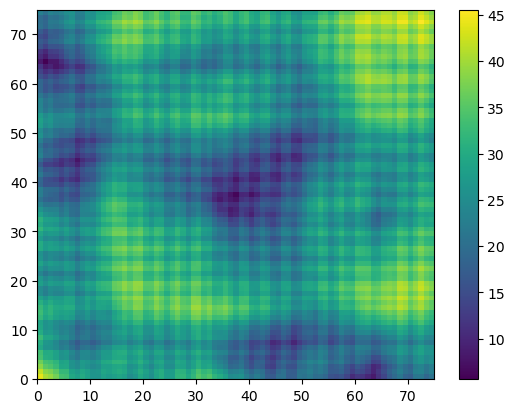

In [7]:
plt.pcolormesh(test_dmat)
plt.colorbar()

In [8]:
# Using the upper triangular part excluding the diagonal to avoid redundancy
# testing for the first segment only (0)
upper_triangle = test_dmat[np.triu_indices(test_dmat.shape[0], k=1)]

In [9]:
upper_triangle

array([40.292, 39.299, 37.014, ..., 43.541, 41.399, 39.326])

In [10]:
upper_triangle.shape

(2775,)

Originally, I thought it would be useful to take the upper triangle since e.g. a CA-CA inter dmat would be symmetric about the diagonal, but I'm using a inter monomer dmat, so as you can see on the plot, it's not completely symmetric. Meaning I need to use the entire dmat.

In [11]:
test_dmat.flatten().shape

(5625,)

In [12]:
dmat_feat_len = dap.h5[f"iterations/iter_{1:08d}/auxdata/inter_ca_dmat"][0].flatten().shape[0]

In [13]:
dmat_feat_len

5625

In [14]:
def get_full_coords(walker_tuple, data_name, data_index=0, first_iter=1):
    """
    Returns a full 1D set of data for a single trace (path).
    This will be ordered from the first iter to the last.

    Parameters
    ----------
    walker_tuple : tuple
        (iteration, walker) start point to trace from.
    data_name : str
        Name of dataset.
    data_index : int
        Index of dataset.
    first_iter : int
        Iter to trace back to. Default 1.
        
    Returns
    -------
    coordinates : 1d array
        Array of coordinates from the list of (iteration, walker) tuples.
    """
    # account for non-pcoord input strings
    if data_name != "pcoord":
        data_name = "auxdata/" + data_name

    path = dap.trace_walker(walker_tuple, first_iter)
    # Initialize an array for the pcoords (rows: n_iters, cols: dmat_feat_len)
    coords = np.zeros((len(path),dmat_feat_len))
    
    # Loop over the path and get the pcoords for each walker
    # path will be ordered from the first iter to the last.
    for idx, (it, wlk) in enumerate(path):
        # convert 75x75 dmat to 1d feature array
        dmat_flat = dap.h5[f"iterations/iter_{it:08d}/{data_name}"][wlk].flatten()
        
        # fill out the array
        coords[idx,:] = dmat_flat

    return coords 

In [15]:
# Can try with only last percentage of data (e.g. 300ns +) 
# Need to prob cut tau, no just need to put a first iter
def get_dmats_ordered(data_name, save_name=None, first_iter=1):
    """
    Parameters
    ----------
    data_name : str
        Name of the dataset in the west.h5 file.
    save_name : str
        Name to save data as (ext .npy), default None, which uses
        data_name.npy. Otherwise will use save_name.npy.
    first_iter : int
        First iter of the h5 file to use.
    """
    # number of states
    n_bstates = len(dap.h5["ibstates/0/bstate_index"])

    if save_name is None:
        save_file_path = data_name
    else:
        save_file_path = save_name
    
    # set n_iters
    n_iters = dap.last_iter - (first_iter - 1)
    
    # pre-cast array for dataset: rows = n_bstates * n_iters, cols = dmat_feat_len
    data_array = np.zeros((n_bstates*n_iters, dmat_feat_len))
    
    # loop each of the 68 long trajectories
    for bs in tqdm(range(n_bstates)):
        # fill out each section of the array based on each full traj of each state
        data_array[bs*n_iters:(bs+1)*n_iters,:] = get_full_coords((dap.last_iter,bs), data_name, first_iter=first_iter)

    np.save(f"{save_file_path}.npy", data_array)
    return data_array

In [16]:
dmat = get_dmats_ordered("inter_ca_dmat", "dmat", 3000)

  0%|          | 0/68 [00:00<?, ?it/s]

Load the inter CA distance matrix as a set of features per frame (each frame is an iteration (100 ps $\tau$))

In [7]:
dmat = np.load("dmat.npy")

In [8]:
dmat.shape

(910384, 5625)

In [17]:
dmat.shape

(706452, 5625)

In [12]:
# smaller dataset for testing
dmat_red = dmat[::100,:]
dmat_red.shape

(9104, 5625)

### Previous Curated Feats

Running these functions again with the full 13k dataset - first 300ns, before only 10k.

Also using only the last frame of each iteration, this way it's consistent with the frequency of saving for the dmatrix data.

In [27]:
def get_full_coords_last_frame(walker_tuple, data_name, data_index=0, first_iter=1, tau=1):
    """
    Returns a full 1D set of data for a single trace (path).
    This will be ordered from the first iter to the last.

    Parameters
    ----------
    walker_tuple : tuple
        (iteration, walker) start point to trace from.
    data_name : str
        Name of dataset.
    data_index : int
        Index of dataset.
    first_iter : int
        Iter to trace back to. Default 1.

    Returns
    -------
    coordinates : 1d array
        Array of coordinates from the list of (iteration, walker) tuples.
    """
    # account for non-pcoord input strings
    if data_name != "pcoord":
        data_name = "auxdata/" + data_name

    path = dap.trace_walker(walker_tuple, first_iter)
    # Initialize an array for the pcoords (each iter * tau)
    coords = np.zeros((len(path)*tau))

    # Loop over the path and get the pcoords for each walker
    # path will be ordered from the first iter to the last.
    for idx, (it, wlk) in enumerate(path):
        # fill out the array in self.tau chunks (here, just grab final frame (-1))
        coords[idx*tau:(idx+1)*tau] = dap._get_data_array(data_name, data_index, it)[wlk][-1]

    return coords  

# can adjust first iter to use less data
def get_data_array_ordered(data_name, save_name=None, first_iter=1, tau=1):
    """
    Parameters
    ----------
    data_name : str
        Name of the dataset in the west.h5 file.
    save_name : str
        Name to save data as (ext .npy), default None, which uses
        data_name.npy. Otherwise will use save_name.npy.
    first_iter : int
        First iter of the h5 file to use.
    """
    # number of states
    n_bstates = len(dap.h5["ibstates/0/bstate_index"])

    if save_name is None:
        save_file_path = data_name
    else:
        save_file_path = save_name
    
    # set n_iters
    n_iters = dap.last_iter - (first_iter - 1)
    
    # pre-cast array for dataset: n_bstates * n_iters * tau
    # to be consistent with dmat, only take final frame of segment (so then tau=1)
    data_array = np.zeros(n_bstates*n_iters*tau)
    
    # loop all segs in final iteration
    for bs in tqdm(range(n_bstates)):
        data_array[bs*n_iters*tau:(bs+1)*n_iters*tau] = \
                                    get_full_coords_last_frame((dap.last_iter,bs), 
                                                                data_name, 
                                                                first_iter=first_iter)

    np.save(f"{save_file_path}.npy", data_array)
    return data_array

In [ ]:
# generate and save data without first 300ns
oa1 = get_data_array_ordered("o_angle_m1", "oa1", 3000)
oa2 = get_data_array_ordered("o_angle_m2", "oa2", 3000)
tt = get_data_array_ordered("tt_dist", "tt", 3000)
m1x1 = get_data_array_ordered("M1_W184_chi1", "m1x1", 3000)
m2x2 = get_data_array_ordered("M2_W184_chi1", "m2x1", 3000)
c2 = get_data_array_ordered("c2_angle", "c2", 3000)

In [38]:
# load input feature data 30p
oa1 = np.load("oa1.npy")
oa2 = np.load("oa2.npy")
tt = np.load("tt.npy")
m1x1 = np.load("m1x1.npy")
m2x1 = np.load("m2x1.npy")
c2 = np.load("c2.npy")

In [39]:
oa1.shape

(706452,)

In [36]:
oa1[706451]

8.366100311279297

In [33]:
test = oa1[:706452]

In [34]:
test[-1]

8.366100311279297

I accidentally created a 10x too large zeros array, chopping and resaving these:

In [37]:
# load input feature data 30p
np.save("oa1.npy", oa1[:706452])
np.save("oa2.npy", oa2[:706452])
np.save("tt.npy", tt[:706452])
np.save("m1x1.npy", m1x1[:706452])
np.save("m2x1.npy", m2x1[:706452])
np.save("c2.npy", c2[:706452])

Okay, done, now it matches with dmat data frequency.

Need to proc the torsion data to account for periodic conditions, function from my ndpredict code.

In [8]:
def proc_angle_data(data):
    """
    Periodic angles (e.g. dihedrals) near periodic boundaries will
    behave poorly since -179° and 179° are actually only 2° away.
    This converts an angle array from degrees to radians, then returns 
    the sin and cos of the radians.

    Parameters
    ----------
    data : array
        1D array of angle values in degrees.

    Returns
    -------
    data_rad_cos_sin : array
        Array of shape (data, 2). For each angle input value, returns the 
        cos and sin output to remove periodicity effects.
    """
    # conver to rads
    data_rad = data * np.pi / 180
    # convert to cos and sin
    data_rad_cos = np.cos(data_rad)
    data_rad_sin = np.sin(data_rad)
    # stack sin and cos arrays:
    data_rad_cos_sin = np.column_stack((data_rad_cos, data_rad_sin))
    return data_rad_cos_sin

In [9]:
m1x1_proc = proc_angle_data(m1x1)
m1x1_proc.shape

(706452, 2)

In [10]:
m2x1_proc = proc_angle_data(m2x1)
m2x1_proc.shape

(706452, 2)

In [11]:
# column stack
features = np.column_stack((oa1,oa2,tt,m1x1_proc,m2x1_proc,c2))
features.shape

(706452, 8)

Now combine with dmat:

In [12]:
dmat.shape

(706452, 5625)

In [13]:
features = np.column_stack((features, dmat))

In [14]:
features.shape

(706452, 5633)

Could also featurize/dim-reduce using input as xyz coords, inter-monomer distance matrices, or feed these to vampNets.

### Standardize features before clustering or dim red

In [383]:
#from sklearn.preprocessing import StandardScaler
## scale data
#scaler = StandardScaler()
#features = scaler.fit_transform(features)

In [15]:
from sklearn.preprocessing import MinMaxScaler
# scale data
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

In [16]:
#from sklearn.preprocessing import normalize
#features = normalize(features, norm='l2')


In [17]:
np.save("features_and_dmat.npy", features)

In [12]:
features = np.load("features_and_dmat.npy")

### Test how good features are using VAMP-2 score, might be useful to test different scaling and norm

In [18]:
from deeptime.decomposition import VAMP

In [19]:
# for curated features
model = VAMP(lagtime=1, dim=10).fit(curated_features).fetch_model()
#deeptime.decomposition.vamp_score(msms[0], 'vamp2')
model.score(r=2)

5.892398033926332

In [ ]:
# for dmat
model = VAMP(lagtime=1, dim=10).fit(dmat).fetch_model()
model.score(r=2)

In [52]:
# for both
model = VAMP(lagtime=1, dim=10).fit(features).fetch_model()
#deeptime.decomposition.vamp_score(msms[0], 'vamp2')
model.score(r=2)

TODO:

* First look at 3 arbitrary lagtimes, compare VAMP2 scores with the two feature sets

* Then use the better one and look at multiple lags and ndims and find how many dims needed based on vamp2 score (note, lagtime diff results are not comparable so this can't be used to select lagtime)

* could eventually add CV-based error bars for each VAMP score

In [21]:
# helper functions to generate a bar plot of VAMP2 score at 3 different lagtimes
def calc_vamp2_scores(feats, vamp_lags=[1, 10, 50], dims=10):
    """
    Calc VAMP2 scores at different lag times.
    Then creates a bar plot.
    
    Parameters
    ----------
    feats : array
        Array of features to score: nrow frames and ncol feats.
    vamp_lags : list of ints
        List of lag times to test.
    dims : int
        n_dims to include in the reduced VAMP model.
        
    Returns
    -------
    scores : list of floats
        VAMP2 scores for each input lagtime.
    """
    scores = []
    # calc vamp2 scores
    for lag in vamp_lags:
        model = VAMP(lagtime=lag, dim=dims).fit(feats).fetch_model()
        scores.append(model.score(r=2))
    #print(scores)
    return scores

In [22]:
cfeat_scores = calc_vamp2_scores(curated_features)
cfeat_scores

[5.892398033926332, 5.306690311723021, 4.819543596125017]

In [26]:
dist_scores = calc_vamp2_scores(dmat)
dist_scores

[10.940937465423783, 10.896450416390376, 10.826998002016342]

In [27]:
feat_scores = calc_vamp2_scores(features)
feat_scores

[10.928843526652061, 10.873871799028558, 10.782515211633598]

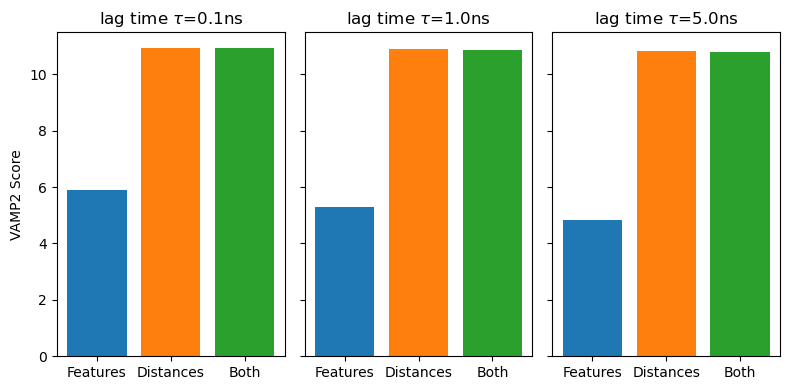

In [31]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(8,4))
vamp_lags=[1, 10, 50]
for i, lag in enumerate(vamp_lags):
    ax[i].bar(["Features"], cfeat_scores[i])
    ax[i].bar(["Distances"], dist_scores[i])
    ax[i].bar(["Both"], feat_scores[i])
    ax[i].set_title(r'lag time $\tau$={:.1f}ns'.format((lag*100)/1000))
    
ax[0].set_ylabel("VAMP2 Score")
plt.tight_layout()
plt.savefig(f"{model_name}/feat_scores.pdf")
plt.show()

In [83]:
def plot_multiple_lags_dims(feats):
    lags = [1, 5, 10, 50, 100]
    dims = [i + 1 for i in range(10)]

    fig, ax = plt.subplots()
    for i, lag in enumerate(lags):
        scores = np.array([calc_vamp2_scores(feats, dims=dim, vamp_lags=[lag])
                            for dim in dims])
        ax.plot(dims, scores, '--o', label='lag={:.1f}ns'.format((lag * 100)/1000))
    ax.legend()
    ax.set_xlabel('Number of Dimensions')
    ax.set_ylabel('VAMP2 score')
    fig.tight_layout()

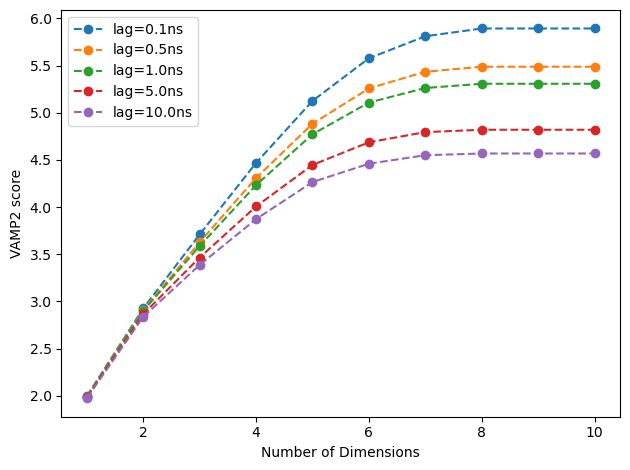

In [84]:
plot_multiple_lags_dims(features)

In [ ]:
# based on the timing for 1 score calc, this will take way too long...
#plot_multiple_lags_dims(dmat)

### tICA or VAMP dim red before clustering

The choice of lagtime here is tricky, but essentially using a smaller one than the MSM is reccomended, since that way the fast processes are not precluded.

See these discussions for more info:
* https://github.com/Acellera/htmd/issues/230
* https://github.com/markovmodel/PyEMMA/issues/1403

For now, going with an arbitrary value of 2 ns, or 20 * 100 ps lag steps.

In [8]:
features.shape

(706452, 5633)

In [9]:
dmat.shape

NameError: name 'dmat' is not defined

In [32]:
from deeptime.decomposition import TICA

In [ ]:
# TODO: could test first with features?
# cutoff with percentage value of to-be captured kinetic variance
model = TICA(dim=None, lagtime=20, var_cutoff=0.8).fit(features).fetch_model()
tica_data = model.transform(features)

In [ ]:
tica_data.shape

In [ ]:
np.save(f"{model_name}/tica.npy", tica_data)

In [ ]:
tica_data = np.load(f"{model_name}/tica.npy")

View marginal and joint distributiosn of tICA with histograms:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()

Now with VAMP:

In [10]:
from deeptime.decomposition import VAMP

In [11]:
model = VAMP(dim=None, lagtime=20, var_cutoff=0.8).fit(features).fetch_model()
vamp_data = model.transform(features)

In [12]:
np.save(f"{model_name}/vamp.npy", vamp_data)

In [13]:
vamp_data = np.load(f"{model_name}/vamp.npy")

In [14]:
vamp_data.shape

(706452, 398)

TODO: View marginal and joint distributiosn of VAMP with histograms:

In [13]:
import mdap

(<Figure size 1000x400 with 6 Axes>, <Axes: xlabel='VAMP0', ylabel='oa1'>)

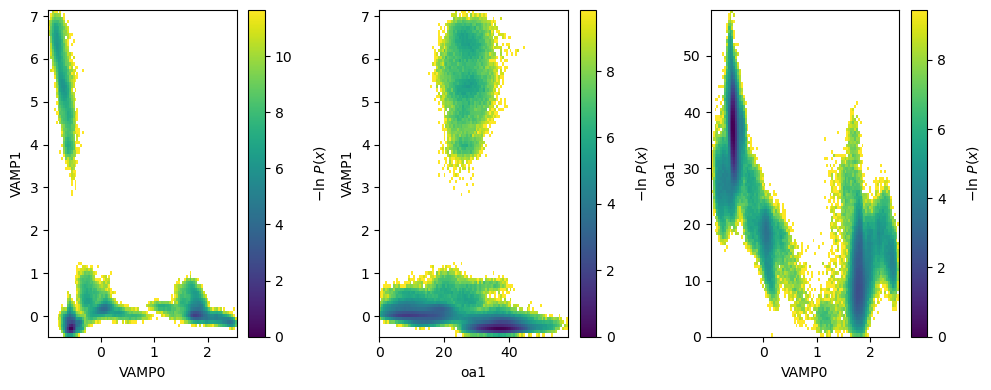

In [26]:
fig, ax = plt.subplots(ncols=3, figsize=(10,4))
mdap.MD_Plot(Xname=vamp_data[:,0], xlabel="VAMP0", Xindex=0, Yname=vamp_data[:,1], ylabel="VAMP1", Yindex=0, data_type="pdist", ax=ax[0]).plot()
mdap.MD_Plot(Xname=oa1, xlabel="oa1", Xindex=0, Yname=vamp_data[:,1], ylabel="VAMP1", Yindex=0, data_type="pdist", ax=ax[1]).plot()
mdap.MD_Plot(Xname=vamp_data[:,0], xlabel="VAMP0", Xindex=0, Yname=oa1, ylabel="oa1", Yindex=0, data_type="pdist", ax=ax[2]).plot()

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time', ylabel='VAMP'>)

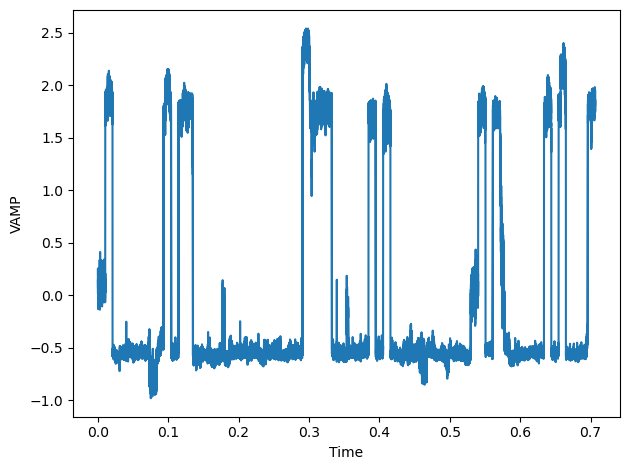

In [29]:
mdap.MD_Plot(Xname=vamp_data, xlabel="Time", ylabel="VAMP", Xindex=0, data_type="time", plot_mode="line").plot()

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='oa1', ylabel='oa2'>)

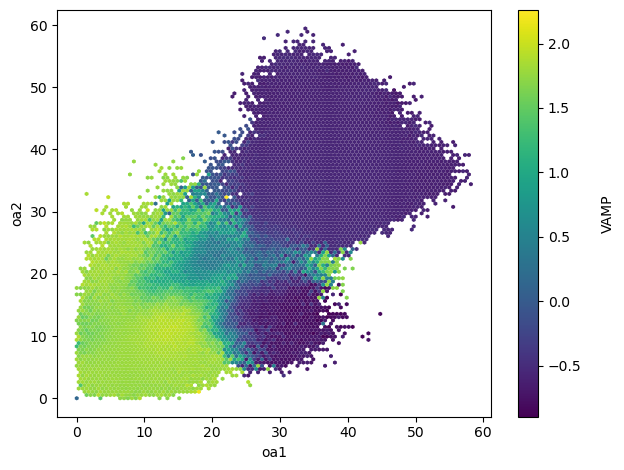

In [36]:
mdap.MD_Plot(Xname=oa1, Yname=oa2, Zname=vamp_data, 
             xlabel="oa1", ylabel="oa2", cbar_label="VAMP", 
             Xindex=0, Yindex=0, Zindex=0, 
             data_type="pdist", plot_mode="hexbin3d").plot()

### Clustering init

In [8]:
# replace features with cfeats
features = curated_features
features.shape

(706452, 8)

In [9]:
n_clusters

[10, 30, 75, 150, 250]

In [10]:
# Run K-means on multiple cluster numbers
clusters = []
dtrajs = []
for n in n_clusters:
    cluster = deeptime.clustering.KMeans(n_clusters=n, max_iter=500, progress=tqdm, n_jobs=n_cpus)
    dtraj = cluster.fit_transform(features)
    dtrajs.append(dtraj)
    clusters.append(cluster.fetch_model())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
# Write previous data
with open(f'{model_name}/clusters.pickle','wb') as file:
    pickle.dump(clusters, file)
with open(f'{model_name}/dtrajs.pickle','wb') as file:
    pickle.dump(dtrajs, file)

## Checkpoint 1/4

In [86]:
# Read previous data
with open(f'{model_name}/clusters.pickle','rb') as file:
    clusters = pickle.load(file)
with open(f'{model_name}/dtrajs.pickle','rb') as file:
    dtrajs = pickle.load(file)

In [43]:
lagtimes

[1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 750, 1000]

In [58]:
n_clusters

[5, 10, 30, 75, 200, 450]

In [12]:
# Make the count matrix for various lagtimes.
#lagtimes = [1, 5, 10, 20, 50, 100, 200, 500, 1000]
countm = []
for dtraj in dtrajs:
    c_small = []
    for lag in lagtimes:
        estimator = deeptime.markov.TransitionCountEstimator(lag, 'sliding')
        c_small.append(estimator.fit(dtraj).fetch_model())
    countm.append(c_small)

In [13]:
# Write previous data
with open(f'{model_name}/countm.pickle','wb') as file:
    pickle.dump(countm, file)

## Checkpoint 2/4

In [13]:
# Read previous data
with open(f'{model_name}/countm.pickle','rb') as file:
    countm = pickle.load(file)

In [14]:
# Make MSM for each cluster/lagtime
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
msms = []
for matrix in countm:
    small = []
    for m, lag in tqdm(zip(matrix, lagtimes)):
        small.append(estimator.fit(m, lagtime=lag).fetch_model())
    msms.append(small)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
# Write previous data
with open(f'{model_name}/msms.pickle','wb') as file:
    pickle.dump(msms, file)

In [19]:
len(msms[0])

12

In [21]:
scores = []
for msm in tqdm(msms):
    for m in msm:
        scores.append(m.score(r=2))

  0%|          | 0/5 [00:00<?, ?it/s]

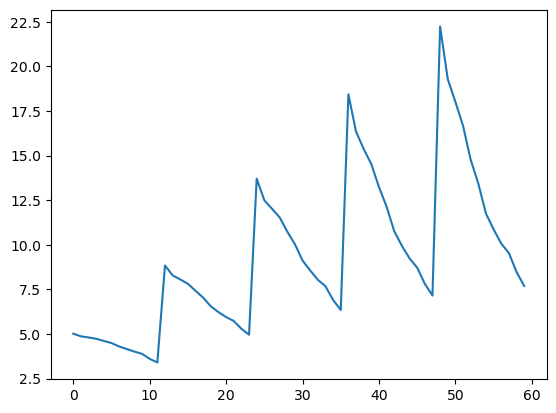

In [22]:
plt.plot(scores)

### To optimize n_clusters: calc VAMP-2 score as a function of cluster centers

In [299]:
dtrajs

[array([2, 2, 2, ..., 1, 1, 1], dtype=int32),
 array([13, 13, 13, ..., 22, 22, 22], dtype=int32),
 array([30, 40, 40, ..., 24, 24, 24], dtype=int32),
 array([  2,  19,  19, ...,  70, 130,  70], dtype=int32),
 array([236, 240, 240, ...,  17, 172,  17], dtype=int32)]

In [300]:
n_clusters

[10, 30, 75, 150, 250]

In [301]:
# Run K-means on multiple different cluster numbers to find an optimal n_clusters
clusters = []
dtrajs = []
for n in [100, 300, 800, 1500]:
    # n_jobs=-1 uses all avail threads (default=None, which uses 1 n_jobs)
    cluster = deeptime.clustering.KMeans(n_clusters=n, max_iter=500, progress=tqdm, n_jobs=n_cpus)
    dtraj = cluster.fit_transform(features)
    dtrajs.append(dtraj)
    clusters.append(cluster.fetch_model())

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [302]:
# Write previous data
with open(f'{model_name}/clusters_opt.pickle','wb') as file:
    pickle.dump(clusters, file)
with open(f'{model_name}/dtrajs_opt.pickle','wb') as file:
    pickle.dump(dtrajs, file)

In [30]:
# Read previous data
with open(f'{model_name}/clusters_opt.pickle','rb') as file:
    clusters = pickle.load(file)
with open(f'{model_name}/dtrajs_opt.pickle','rb') as file:
    dtrajs = pickle.load(file)

In [322]:
# Run K-means on multiple different cluster numbers to find an optimal n_clusters
clusters = []
dtrajs = []
for n in [2000, 3000, 4000]:
    # n_jobs=-1 uses all avail threads (default=None, which uses 1 n_jobs)
    cluster = deeptime.clustering.KMeans(n_clusters=n, max_iter=500, progress=tqdm, n_jobs=n_cpus)
    dtraj = cluster.fit_transform(features)
    dtrajs.append(dtraj)
    clusters.append(cluster.fetch_model())

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [323]:
# Write previous data
with open(f'{model_name}/clusters_opt2.pickle','wb') as file:
    pickle.dump(clusters, file)
with open(f'{model_name}/dtrajs_opt2.pickle','wb') as file:
    pickle.dump(dtrajs, file)

In [30]:
# Read previous data
with open(f'{model_name}/clusters_opt2.pickle','rb') as file:
    clusters = pickle.load(file)
with open(f'{model_name}/dtrajs_opt2.pickle','rb') as file:
    dtrajs = pickle.load(file)

Because this takes a while to run even with reduced VAMP dimensions, running on a separate Python script. Once this is done, can just read in the `clusters_opt` pickle object.

In [324]:
# Making MSM for each cluster at set lagtime
lag = 5

# first make count matrices at each clustering amount
clust_countm = []
tc_estimator = deeptime.markov.TransitionCountEstimator(lag, 'sliding')
for dtraj in dtrajs:
    clust_countm.append(tc_estimator.fit(dtraj).fetch_model())

# Make MSM for each cluster at set lagtime
clust_msms = []
msm_estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
for matrix in clust_countm:
    clust_msms.append(msm_estimator.fit(matrix, lagtime=lag).fetch_model())

In [325]:
#msms[0][0].score(r=2)

In [326]:
len(clust_countm)

3

In [327]:
len(clust_msms)

3

Now the models are scored, which evaluates how much “slowness” is captured with the current input features. 

Note that scores can not be compared across different lagtimes $\tau$.

In [328]:
scores = []
for msm in tqdm(clust_msms):
    scores.append(msm.score(r=2))

  0%|          | 0/3 [00:00<?, ?it/s]

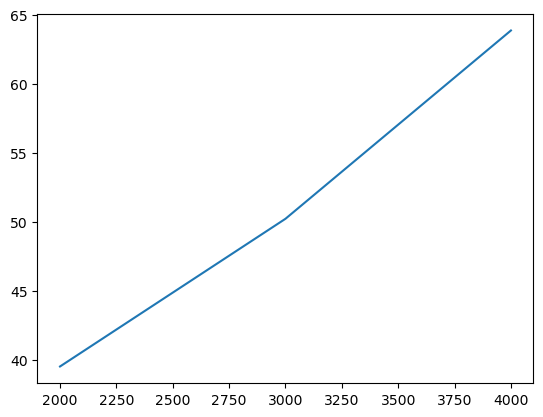

In [330]:
plt.plot([2000,3000,4000], scores)
#plt.semilogx()

In [ ]:
plt.plot([100, 300, 800, 1500], scores)
#plt.semilogx()

#### I also want to test keeping a portion of the VAMP dimensions: 
2, 10, 50, 100, 300, instead of before with full amount for 80% kinetic variance

In [21]:
n_vamp_dims = [2, 10, 50, 100, 300]

In [22]:
# Run K-means on multiple different cluster numbers to find an optimal n_clusters
clusters = []
dtrajs = []
for n in [40, 80, 120, 180, 250]:
    for v in n_vamp_dims:
        # n_jobs=-1 uses all avail threads (default=None, which uses 1 n_jobs)
        cluster = deeptime.clustering.KMeans(n_clusters=n, max_iter=500, progress=tqdm, n_jobs=n_cpus)
        dtraj = cluster.fit_transform(vamp_data[:,:v])
        dtrajs.append(dtraj)
        clusters.append(cluster.fetch_model())

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
# Write previous data
with open(f'{model_name}/clusters_opt3.pickle','wb') as file:
    pickle.dump(clusters, file)
with open(f'{model_name}/dtrajs_opt3.pickle','wb') as file:
    pickle.dump(dtrajs, file)

In [184]:
# Read previous data
with open(f'{model_name}/clusters_opt3.pickle','rb') as file:
    clusters = pickle.load(file)
with open(f'{model_name}/dtrajs_opt3.pickle','rb') as file:
    dtrajs = pickle.load(file)

In [25]:
# Making MSM for each cluster at set lagtime (TODO: 3 diff lagtimes?)
lag = 30

# first make count matrices at each clustering amount
clust_countm = []
tc_estimator = deeptime.markov.TransitionCountEstimator(lag, 'sliding')
for dtraj in dtrajs:
    clust_countm.append(tc_estimator.fit(dtraj).fetch_model())

# Make MSM for each cluster at set lagtime
clust_msms = []
msm_estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
for matrix in clust_countm:
    clust_msms.append(msm_estimator.fit(matrix, lagtime=lag).fetch_model())

In [26]:
scores = []
for msm in tqdm(clust_msms):
    scores.append(msm.score(r=2))

  0%|          | 0/25 [00:00<?, ?it/s]

In [27]:
xax = np.array([[n_vamp_dims]*6]).flatten()

In [28]:
xax

array([  2,  10,  50, 100, 300,   2,  10,  50, 100, 300,   2,  10,  50,
       100, 300,   2,  10,  50, 100, 300,   2,  10,  50, 100, 300,   2,
        10,  50, 100, 300])

In [29]:
len(scores)

25

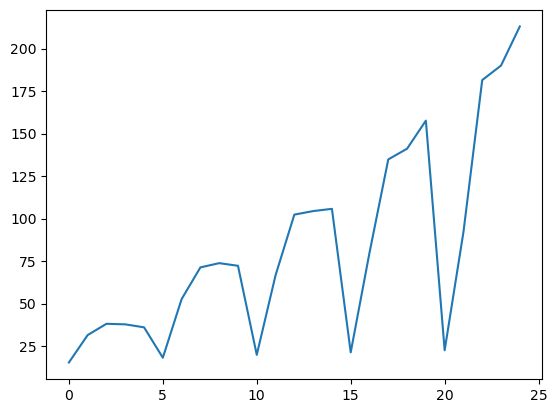

In [30]:
plt.plot(scores)
plt.show()

Let's go with 120 `n_clusters` and 50 `n_vamp_dims` for now... seems to provide a converged vamp2 score.

In [87]:
clust_msms[17]

MarkovStateModelCollection-140554123690432:[{'count_models': None,
                                            'reversible': True,
                                            'stationary_distributions': None,
                                            'transition_matrices': None,
                                            'transition_matrix_tolerance': 1e-06}]

Tried to make model intiially with 120 k and 50 v at multiple lag times:
* this couldn't converge due to empty cluster centers
* optimizing the values further...

In [31]:
lagtimes = [1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 1000]

In [32]:
n=120
v=50

# n_jobs=-1 uses all avail threads (default=None, which uses 1 n_jobs)
cluster = deeptime.clustering.KMeans(n_clusters=n, max_iter=500, progress=tqdm, n_jobs=n_cpus)
dtraj = cluster.fit_transform(vamp_data[:,:v])


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [33]:
# Make the count matrix for various lagtimes
countm = []
for lag in tqdm(lagtimes):
    estimator = deeptime.markov.TransitionCountEstimator(lag, 'sliding')
    countm.append(estimator.fit(dtraj).fetch_model())
    
# Make MSM for each cluster/lagtime
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
msms = []
for m, lag in tqdm(zip(countm, lagtimes)):
    msms.append(estimator.fit(m, lagtime=lag).fetch_model())

  0%|          | 0/11 [00:00<?, ?it/s]

0it [00:00, ?it/s]

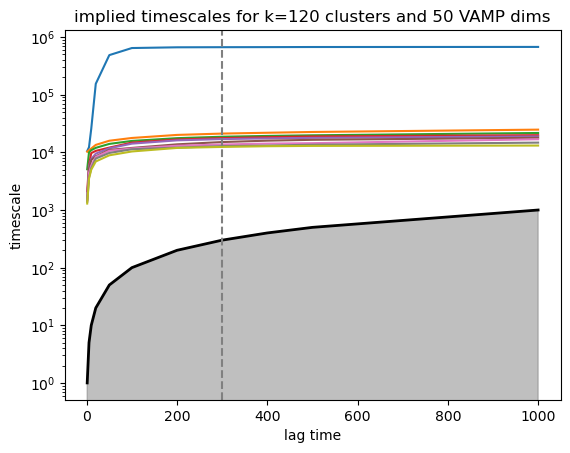

In [34]:
plot = deeptime.plots.plot_implied_timescales(
    deeptime.util.validation.implied_timescales(msms, n_its=9))
plot.set_xlabel('lag time');
plot.set_ylabel('timescale');
plot.set_title(f'implied timescales for k={n} clusters and {v} VAMP dims');
#plot.set_ylim(0,10);
plot.axvline(300, linestyle='--', color='grey');
#plot.axvline(500, linestyle='--', color='grey');
#plot.axvline(1000, linestyle='--', color='grey');
#plot.axvline(2000, linestyle='--', color='grey');
#plot.axvline(5000, linestyle='--', color='grey');
#plot.legend(lagtimes,loc='upper right');
#plot.legend(loc='upper right');
plot.set_yscale("log")
## Choosing 10ps * 5ps = report every 50 ps
plot.figure.savefig(f'{model_name}/{n}k_{v}vamp_its.pdf')

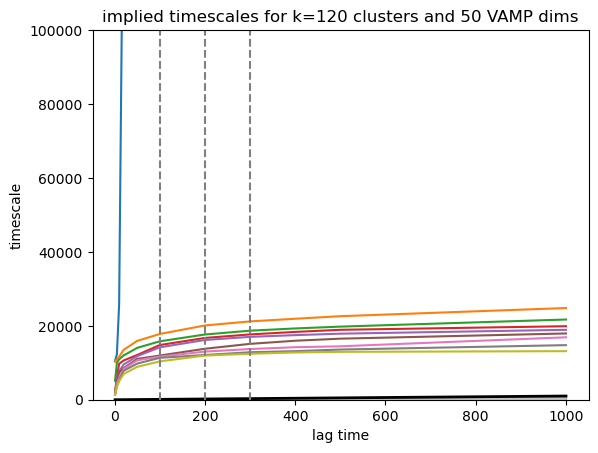

In [36]:
plot = deeptime.plots.plot_implied_timescales(
    deeptime.util.validation.implied_timescales(msms, n_its=9))
plot.set_xlabel('lag time');
plot.set_ylabel('timescale');
plot.set_title(f'implied timescales for k={n} clusters and {v} VAMP dims');
plot.set_ylim(0,100000);
plot.axvline(300, linestyle='--', color='grey');
plot.axvline(200, linestyle='--', color='grey');
plot.axvline(100, linestyle='--', color='grey');
#plot.axvline(500, linestyle='--', color='grey');
#plot.axvline(1000, linestyle='--', color='grey');
#plot.axvline(2000, linestyle='--', color='grey');
#plot.axvline(5000, linestyle='--', color='grey');
#plot.legend(lagtimes,loc='upper right');
#plot.legend(loc='upper right');
#plot.set_yscale("log")
## Choosing 10ps * 5ps = report every 50 ps
plot.figure.savefig(f'{model_name}/{n}k_{v}vamp_its_linear.pdf')

Final model = 120 microstates, 50 VAMP dimensions, 200 lagtime (20ns)

In [38]:
final_lag = 200
final_cluster = cluster
final_dtrajs = dtraj
estimator = deeptime.markov.TransitionCountEstimator(final_lag, 'sliding')
final_count = estimator.fit(final_dtrajs).fetch_model()
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
final_msm = estimator.fit(final_count, lagtime=final_lag).fetch_model()

In [39]:
final_msm

MarkovStateModelCollection-139939511626352:[{'count_models': None,
                                            'reversible': True,
                                            'stationary_distributions': None,
                                            'transition_matrices': None,
                                            'transition_matrix_tolerance': 1e-06}]

In [164]:
# Read previous data
with open(f'{model_name}/finalmsm_opt_vamp.pickle','rb') as file:
    [final_cluster, final_dtrajs, final_count, final_msm] = pickle.load(file)

In [41]:
# Write previous data
with open(f'{model_name}/finalmsm_opt_vamp.pickle','wb') as file:
    pickle.dump([final_cluster, final_dtrajs, final_count, final_msm], file)

## Checkpoint 3/4

In [15]:
# Read previous data
with open(f'{model_name}/clusters.pickle','rb') as file:
    clusters = pickle.load(file)
with open(f'{model_name}/dtrajs.pickle','rb') as file:
    dtrajs = pickle.load(file)

In [16]:
# Read previous data
with open(f'{model_name}/msms.pickle','rb') as file:
    msms = pickle.load(file)

In [17]:
lagtimes

[1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 750, 1000]

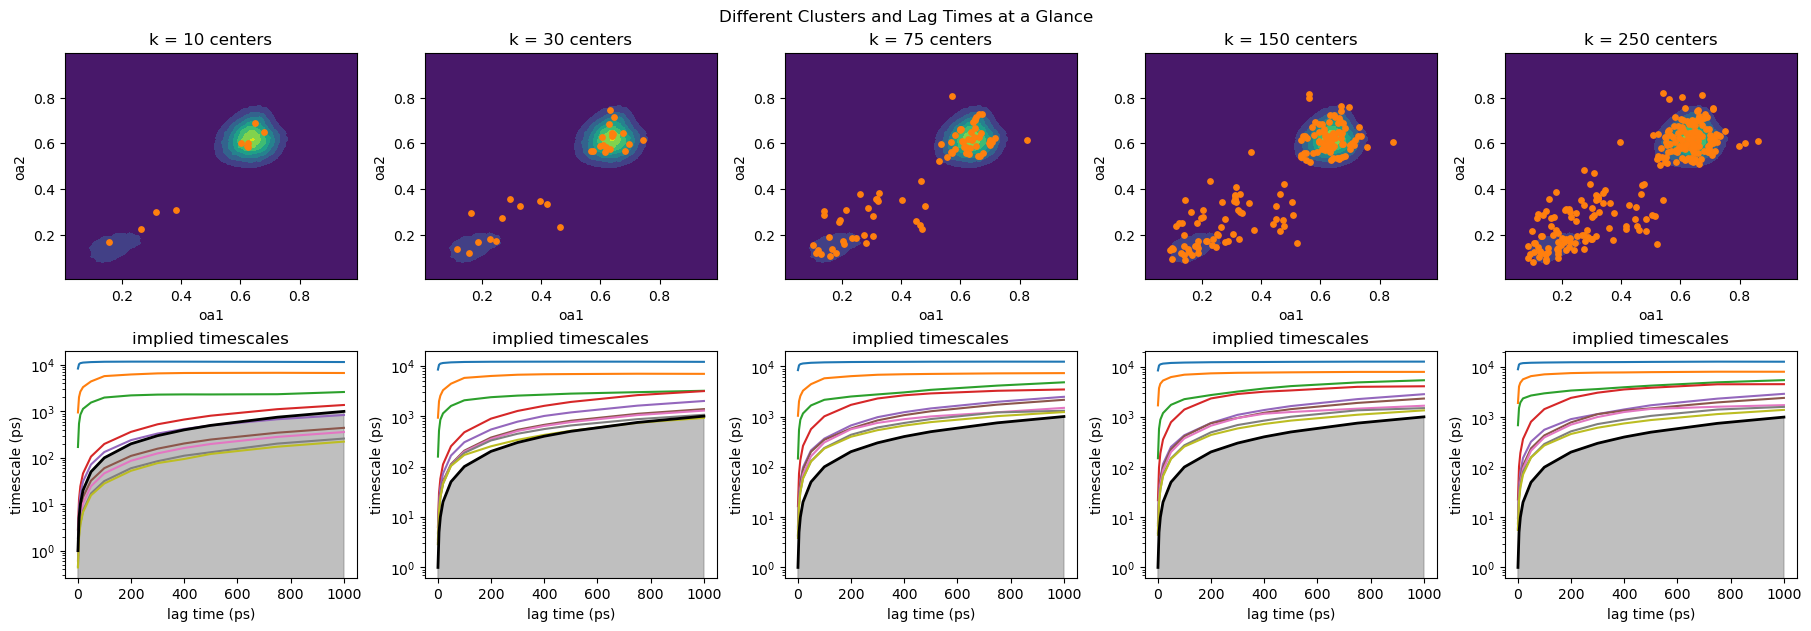

In [23]:
# Try and plot the many different cluster centers

# Setting up the figure/Axes objects...
fig = plt.figure(constrained_layout=True, figsize=(18,6.2))
gs = fig.add_gridspec(2, len(n_clusters))
axes = []
for idx in range(2):
    axes.append([])
    for jdx in range(len(n_clusters)):
        axes[idx].append(fig.add_subplot(gs[idx, jdx]))
axes = np.asarray(axes)
# This is a simplified way to setup but might create overlap
#fig, axes = plt.subplots(2, len(n_clusters), figsize=(18, 6.2))

# Plotting things...
for i, (n, cluster, dtraj, msm) in enumerate(zip(n_clusters, clusters, dtrajs, msms)):
    # Top row...
    deeptime.plots.plot_density(*features[:,:2].T[::-1], ax=axes[0, i]) # Note .T reverses Phi/Psi
    axes[0, i].scatter(*cluster.cluster_centers[:,:2].T, s=15, c='C1')
    axes[0, i].set_xlabel('oa1')
    axes[0, i].set_ylabel('oa2')
    axes[0, i].set_title('k = {} centers'.format(n))
    #axes[0, i].set_xticks([j for j in range(-180,181,60)])
    #axes[0, i].set_xticks([j for j in range(-180,181,60)])
    
    # Bottom row...
    deeptime.plots.plot_implied_timescales(
        deeptime.util.validation.implied_timescales(msm, n_its=9),
        ax=axes[1, i])
    axes[1, i].set_xlabel('lag time (ps)')
    axes[1, i].set_ylabel('timescale (ps)')
    axes[1, i].set_yscale('log')
    axes[1, i].set_title('implied timescales')
    #axes[1, i].set_ylim(1, 2000)

#fig.tight_layout()
fig.suptitle('Different Clusters and Lag Times at a Glance')
fig.savefig(f'{model_name}/its.pdf')

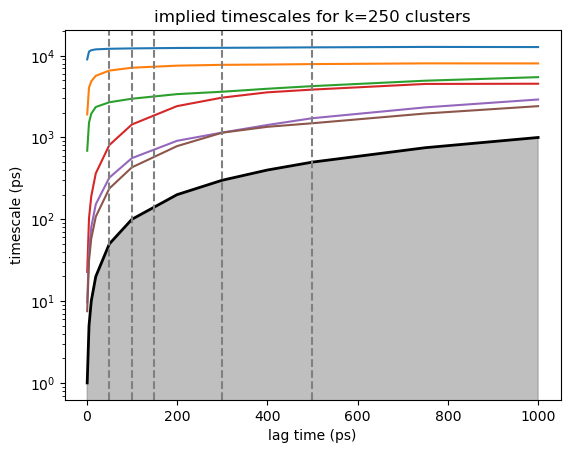

In [435]:
# Blowing one of the implied timescale plot up by replotting it.
index = -1
plot = deeptime.plots.plot_implied_timescales(
    deeptime.util.validation.implied_timescales(msms[index], n_its=6))
plot.set_xlabel('lag time (ps)');
plot.set_ylabel('timescale (ps)');
plot.set_title(f'implied timescales for k={n_clusters[index]} clusters');
#plot.set_ylim(0,10);
plot.axvline(50, linestyle='--', color='grey');
plot.axvline(100, linestyle='--', color='grey');
plot.axvline(150, linestyle='--', color='grey');
plot.axvline(500, linestyle='--', color='grey');
plot.axvline(300, linestyle='--', color='grey');
#plot.axvline(1000, linestyle='--', color='grey');
#plot.axvline(2000, linestyle='--', color='grey');
#plot.axvline(5000, linestyle='--', color='grey');
#plot.legend(lagtimes,loc='upper right');
#plot.legend(loc='upper right');
plot.set_yscale("log")
## Choosing 10ps * 5ps = report every 50 ps
plot.figure.savefig(f'{model_name}/final_its.pdf')

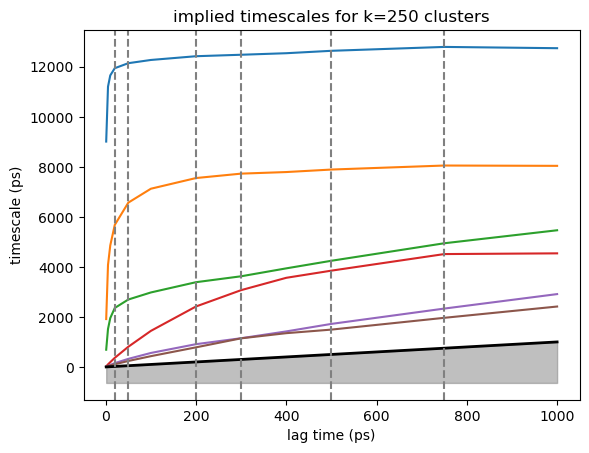

In [436]:
# Blowing one of the implied timescale plot up by replotting it.
index = -1
plot = deeptime.plots.plot_implied_timescales(
    deeptime.util.validation.implied_timescales(msms[index], n_its=6))
plot.set_xlabel('lag time (ps)');
plot.set_ylabel('timescale (ps)');
plot.set_title(f'implied timescales for k={n_clusters[index]} clusters');
#plot.set_ylim(0,2000);
plot.axvline(500, linestyle='--', color='grey');
plot.axvline(750, linestyle='--', color='grey');
plot.axvline(200, linestyle='--', color='grey');
plot.axvline(50, linestyle='--', color='grey');
plot.axvline(20, linestyle='--', color='grey');
plot.axvline(300, linestyle='--', color='grey');
#plot.axvline(1000, linestyle='--', color='grey');
#plot.axvline(2000, linestyle='--', color='grey');
#plot.axvline(5000, linestyle='--', color='grey');
#plot.legend(lagtimes,loc='upper right');
plot.figure.savefig(f'{model_name}/final_its_linear.pdf')

In [18]:
final_lag = 1
index = -1
final_cluster= clusters[index]
final_dtrajs = dtrajs[index][:]
estimator = deeptime.markov.TransitionCountEstimator(final_lag, 'sliding')
final_count = estimator.fit(final_dtrajs).fetch_model()
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
final_msm = estimator.fit(final_count, lagtime=None).fetch_model()

In [19]:
print('fraction of states used = {:.2f}'.format(final_msm.state_fraction))
print('fraction of counts used = {:.2f}'.format(final_msm.count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


In [23]:
# Write data
with open(f'{model_name}/final-1step-lag.pickle','wb') as file:
    pickle.dump([final_cluster, final_dtrajs, final_count, final_msm], file)

#### Can load from here or from above previous section:

In [20]:
final_dtrajs.shape

(706452,)

In [21]:
final_msm.transition_matrix

array([[0.14731785, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05331627, 0.        , ..., 0.00202603, 0.        ,
        0.00106633],
       [0.        , 0.        , 0.19565217, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0025313 , 0.        , ..., 0.06528111, 0.        ,
        0.02158272],
       [0.        , 0.        , 0.        , ..., 0.        , 0.20903697,
        0.        ],
       [0.        , 0.00099502, 0.        , ..., 0.01611942, 0.        ,
        0.07223881]])

In [ ]:
plt.imshow(final_msm.transition_matrix, vmax=0.1, cmap="gnuplot")
plt.colorbar()

In [347]:
# Read previous data
with open(f'{model_name}/final.pickle','rb') as file:
    [final_cluster, final_dtrajs, final_count, final_msm] = pickle.load(file)

In [44]:
# Write previous data
with open(f'{model_name}/final.pickle','wb') as file:
    pickle.dump([final_cluster, final_dtrajs, final_count, final_msm], file)

### TODO: MSM ITS / spectral analysis to further confirm n macrostates

In [461]:
mean_timescales = []
std_timescales = []
for i in range(10):
    ts = deeptime.util.validation.implied_timescales(msms[-1], n_its=10).timescales_for_process(i)
    mean_timescales.append(np.mean(ts))
    std_timescales.append(np.std(ts))

<ErrorbarContainer object of 3 artists>

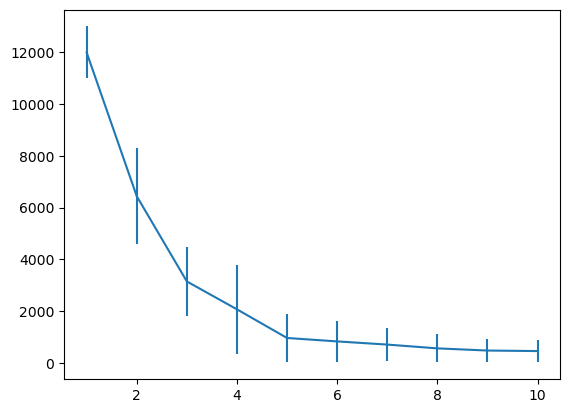

In [462]:
plt.errorbar([i for i in range(1,11)], mean_timescales, yerr=std_timescales)

### CK test for MSM Markovianity with n number of macrostates

In [371]:
from deeptime.markov.msm import BayesianMSM
from deeptime.plots.chapman_kolmogorov import plot_ck_test

In [543]:
lag=200

In [544]:
estimator = deeptime.markov.TransitionCountEstimator(lagtime=lag, count_mode='effective')
final_bmsm = BayesianMSM().fit_fetch(estimator.fit_fetch(final_dtrajs))

In [545]:
ck_test = final_msm.ck_test(msms[0], n_metastable_sets=3)

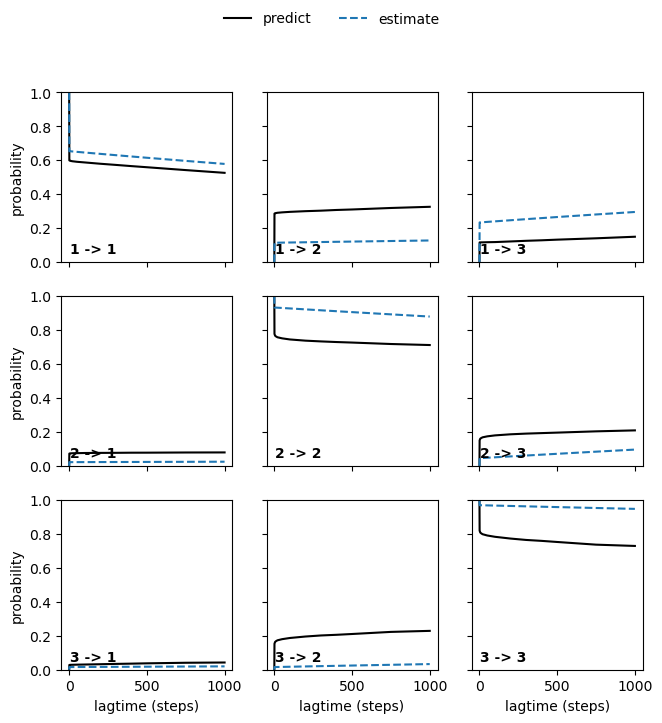

In [546]:
plot_ck_test(ck_test)

With error:

In [537]:
lagtimes

[1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 750, 1000]

Bayesian MSM

Getting an error related to: https://github.com/markovmodel/PyEMMA/issues/714

Likely I have too many clusters and at longer lagtimes the clusters are not populated.

In [376]:
models = []
for lag in tqdm(lagtimes):
    counts_estimator = deeptime.markov.TransitionCountEstimator(lagtime=lag, count_mode='effective')
    models.append(BayesianMSM().fit_fetch(counts_estimator.fit_fetch(final_dtrajs).submodel_largest()))

  0%|          | 0/12 [00:00<?, ?it/s]

CK Plots

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

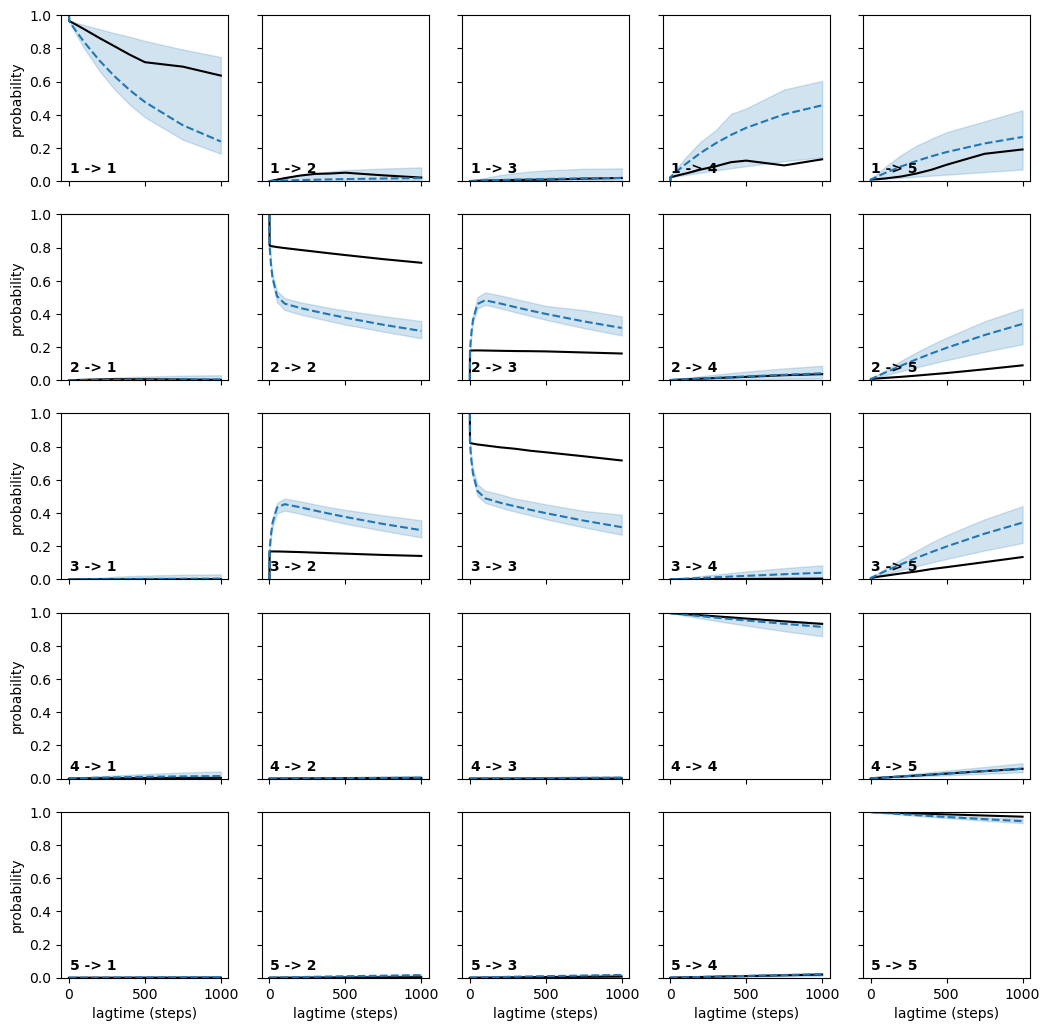

In [379]:
test_model = models[0]
ck_test = test_model.ck_test(models, n_metastable_sets=5, progress=tqdm)
grid = plot_ck_test(ck_test, legend=False)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

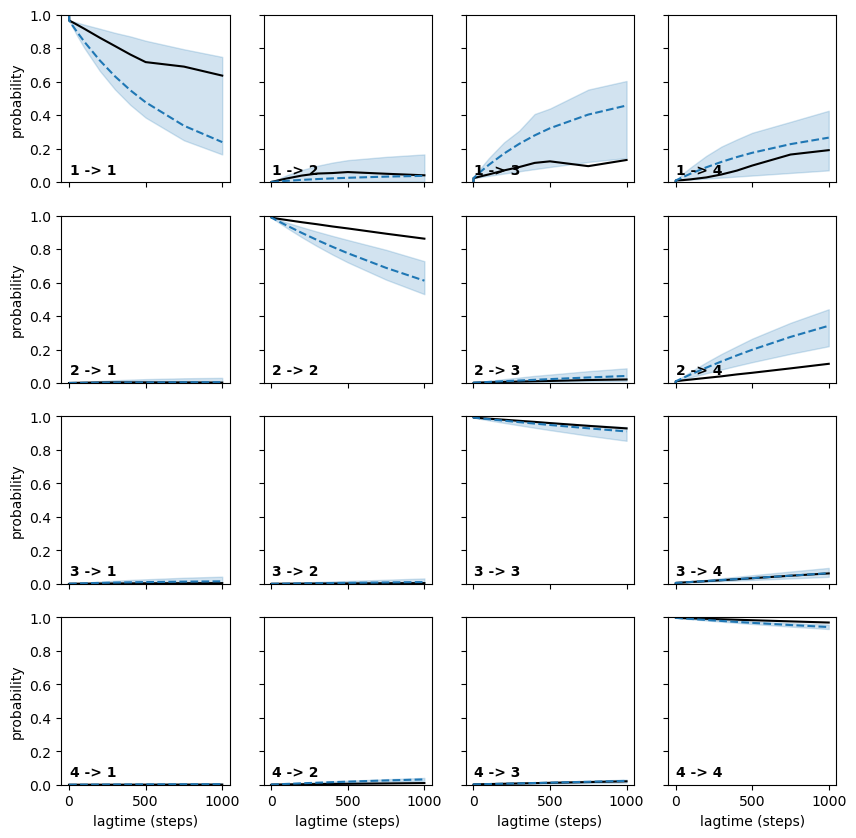

In [380]:
test_model = models[0]
ck_test = test_model.ck_test(models, n_metastable_sets=4, progress=tqdm)
grid = plot_ck_test(ck_test, legend=False)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

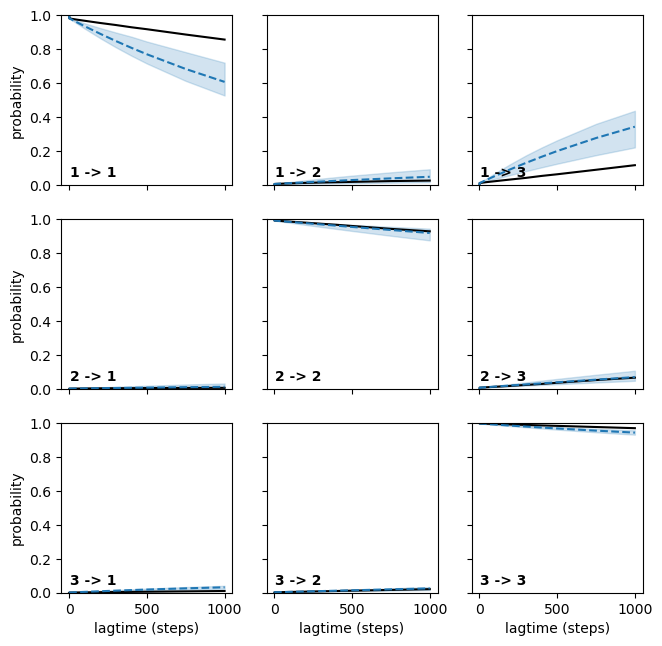

In [381]:
test_model = models[0]
ck_test = test_model.ck_test(models, n_metastable_sets=3, progress=tqdm)
grid = plot_ck_test(ck_test, legend=False)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

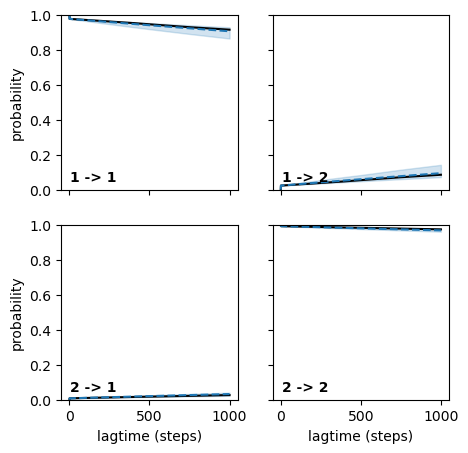

In [382]:
test_model = models[0]
ck_test = test_model.ck_test(models, n_metastable_sets=2, progress=tqdm)
grid = plot_ck_test(ck_test, legend=False)

### Plot stationary dist and reweighted free energy 
(also look at ∆kT of D1 and D2 and compare to W184 N$\epsilon$ HSQC)

In [11]:
# Read previous data
with open(f'{model_name}/final.pickle','rb') as file:
    [final_cluster, final_dtrajs, final_count, final_msm] = pickle.load(file)

In [236]:
features = curated_features

In [24]:
weights = final_msm.compute_trajectory_weights(final_dtrajs)

In [238]:
final_dtrajs.shape

(706452,)

In [239]:
final_msm.stationary_distribution.shape

(250,)

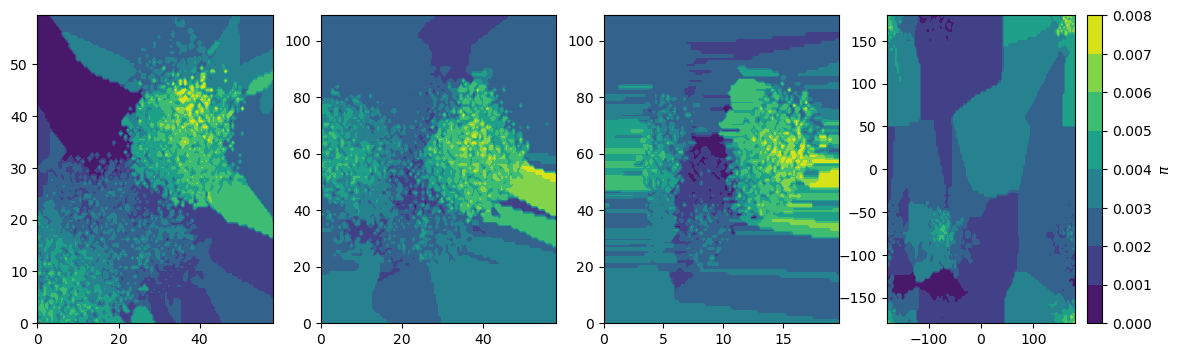

In [240]:
fig, ax = plt.subplots(ncols=4, figsize=(14, 4))

plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    oa1, oa2,
    final_msm.stationary_distribution[final_dtrajs], ax=ax[0])
plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    oa1, c2,
    final_msm.stationary_distribution[final_dtrajs], ax=ax[1])
plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    tt, c2,
    final_msm.stationary_distribution[final_dtrajs], ax=ax[2])
plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    m1x1, m2x1,
    final_msm.stationary_distribution[final_dtrajs], ax=ax[3])

cbar = plt.colorbar(mapping)
cbar.set_label('$\pi$')

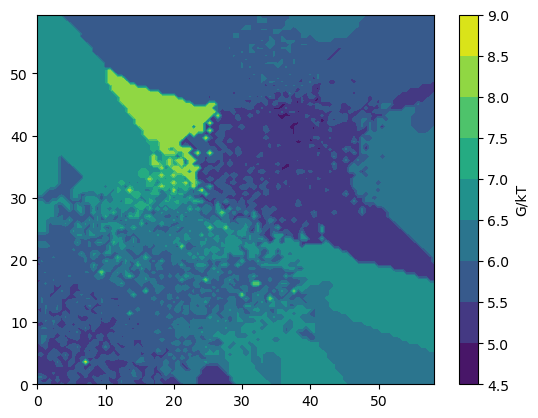

In [241]:
plot, mapping = deeptime.plots.plot_contour2d_from_xyz(
    oa1, oa2,
    -np.log(final_msm.stationary_distribution[final_dtrajs]), ax=None)
cbar = plt.colorbar(mapping)
cbar.set_label('G/kT')

In [242]:
features.shape

(706452, 8)

In [243]:
weights[0].shape

(706452,)

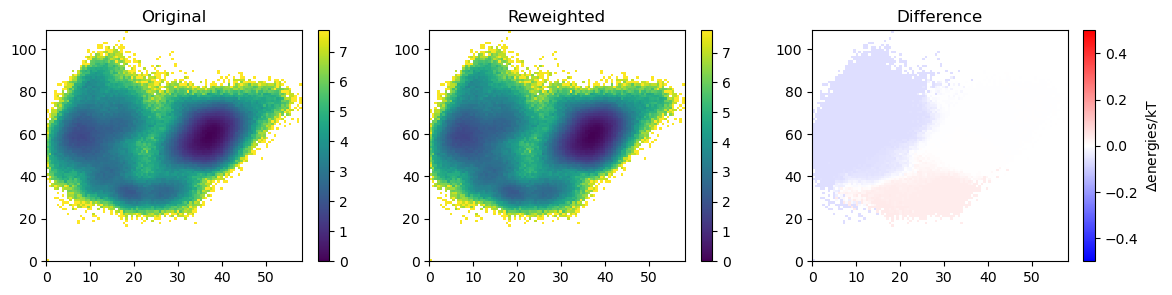

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = oa1
f2 = c2
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

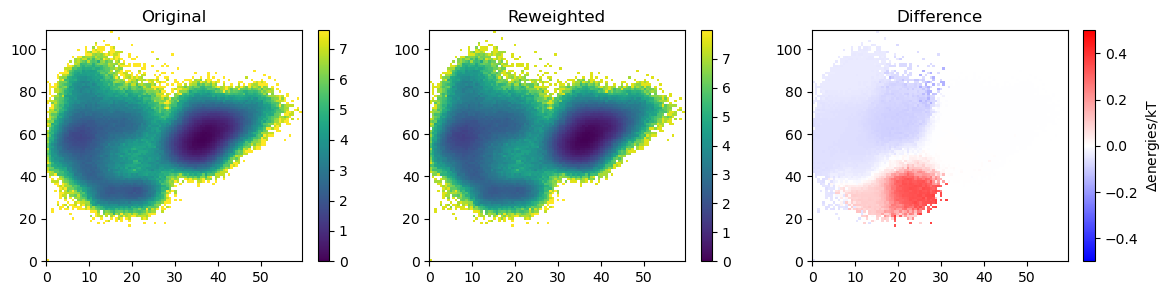

In [245]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = oa2
f2 = c2
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

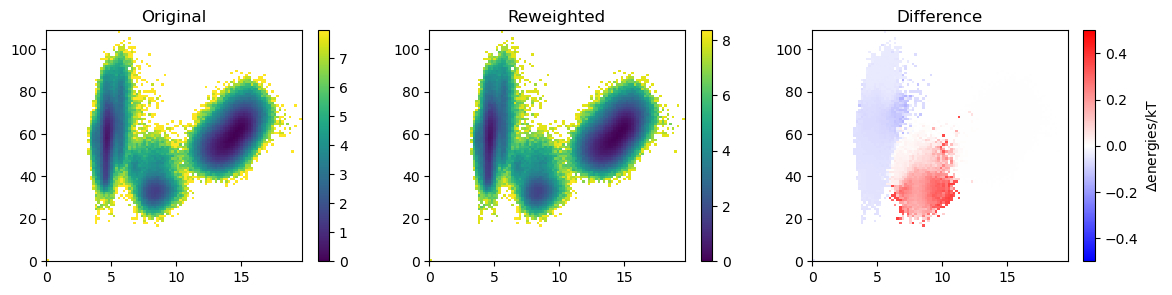

In [246]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = tt
f2 = c2
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

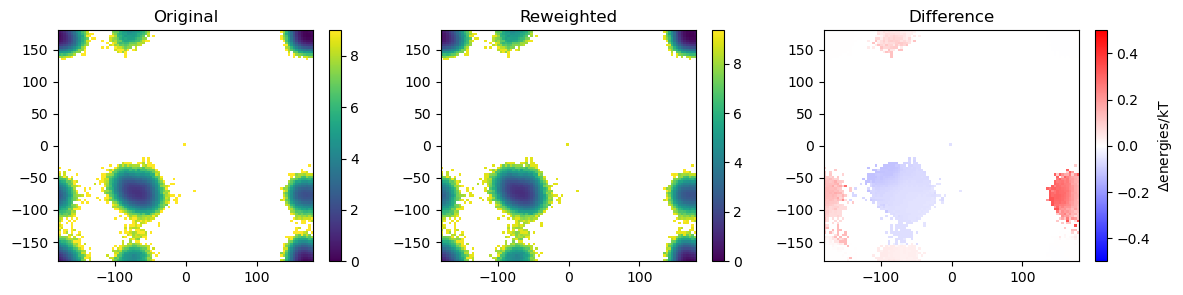

In [159]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = m1x1
f2 = m2x1
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

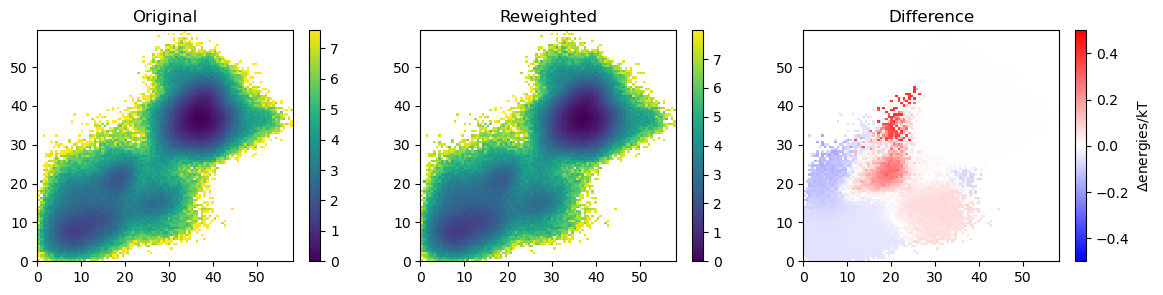

In [237]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = oa1
f2 = oa2
energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

In [247]:
energies.x_meshgrid.shape

(100,)

In [248]:
# Find the index of the value closest to the input value
oa = 9
xidx = np.argmin(np.abs(energies.x_meshgrid - oa))
yidx = np.argmin(np.abs(energies.y_meshgrid - oa))
xidx,yidx

(45, 8)

In [249]:
d2_energy = energies.energies[xidx,yidx]
d2_energy

inf

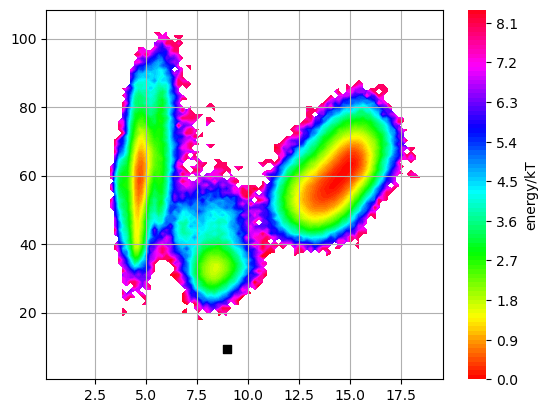

In [250]:
plot = deeptime.plots.plot_energy2d(energies, contourf_kws={'cmap':'hsv'})
plot.colorbar.set_label('energy/kT')
plt.grid()
plt.scatter(energies.x_meshgrid[xidx], energies.y_meshgrid[yidx], marker='s', color='k')
#dir(plot)

In [169]:
# Find the index of the value closest to the input value
oa = 38
xidx = np.argmin(np.abs(energies.x_meshgrid - oa))
yidx = np.argmin(np.abs(energies.y_meshgrid - oa))
xidx,yidx

(65, 63)

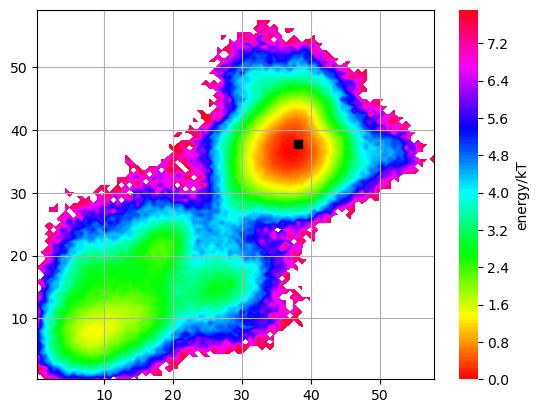

In [170]:
plot = deeptime.plots.plot_energy2d(energies, contourf_kws={'cmap':'hsv'})
plot.colorbar.set_label('energy/kT')
plt.grid()
plt.scatter(energies.x_meshgrid[xidx], energies.y_meshgrid[yidx], marker='s', color='k')
#dir(plot)

In [171]:
d1_energy = energies.energies[xidx,yidx]
d1_energy

0.13101404279962292

### Run PCCA++, plot each fuzzy clusters and course grained tmatrix

And convert dist into crisp assignments

In [10]:
# Read previous data
with open(f'{model_name}/final.pickle','rb') as file:
    [final_cluster, final_dtrajs, final_count, final_msm] = pickle.load(file)

In [172]:
import networkx as nx

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

threshold = 5e-3
title = f"Transition matrix with connectivity threshold {threshold:.0e}"
G = nx.DiGraph()
ax.set_title(title)
for i in range(final_msm.n_states):
    G.add_node(i, title=f"{i}")
for i in range(final_msm.n_states):
    for j in range(final_msm.n_states):
        if final_msm.transition_matrix[i, j] > threshold:
            G.add_edge(i, j, title=f"{final_msm.transition_matrix[i, j]:.3e}")

edge_labels = nx.get_edge_attributes(G, 'title')
pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, labels=nx.get_node_attributes(G, 'title'));
nx.draw_networkx_edges(G, pos, ax=ax, arrowstyle='-|>',
                       connectionstyle='arc3, rad=0.3');

plt.savefig(f"{model_name}/tmat_network.pdf")

At middles:

In [381]:
final_cluster.cluster_centers[224]

array([11.23447257, 16.35939833,  5.34635915,  0.35108069, -0.90253196,
        0.40419305, -0.88536617, 79.91734316])

### PCCA++

In [26]:
# 3 states seems to work well
pcca = final_msm.pcca(n_metastable_sets=3)

In [27]:
pcca.memberships

array([[9.26600886e-05, 9.99371033e-01, 5.36306722e-04],
       [4.00475587e-04, 1.69596744e-04, 9.99429928e-01],
       [9.97459272e-01, 2.13118958e-03, 4.09538056e-04],
       [3.50437568e-05, 9.99212666e-01, 7.52289910e-04],
       [1.19418242e-04, 1.02846135e-04, 9.99777736e-01],
       [3.25233937e-02, 6.00449898e-01, 3.67026708e-01],
       [5.69498971e-04, 2.18854088e-04, 9.99211647e-01],
       [1.25686671e-04, 9.99237225e-01, 6.37088623e-04],
       [1.18964352e-04, 9.99385959e-01, 4.95076619e-04],
       [2.70265448e-04, 1.35852702e-04, 9.99593882e-01],
       [7.12697929e-04, 5.04556447e-04, 9.98782746e-01],
       [3.13647462e-04, 1.55368080e-04, 9.99530984e-01],
       [2.12269552e-04, 1.15659499e-04, 9.99672071e-01],
       [5.33742666e-05, 9.99414793e-01, 5.31832471e-04],
       [5.78651656e-04, 1.98805180e-04, 9.99222543e-01],
       [9.96502161e-01, 8.87616223e-05, 3.40907769e-03],
       [1.69638067e-03, 5.96734320e-04, 9.97706885e-01],
       [6.93905443e-04, 9.98871

In [28]:
pcca.coarse_grained_stationary_probability

array([0.06294942, 0.23903951, 0.69801107])

In [29]:
pcca.coarse_grained_transition_matrix

array([[9.99515387e-01, 4.89351680e-05, 4.35677460e-04],
       [1.29807441e-05, 9.99915193e-01, 7.18266880e-05],
       [3.92589389e-05, 2.46298190e-05, 9.99936111e-01]])

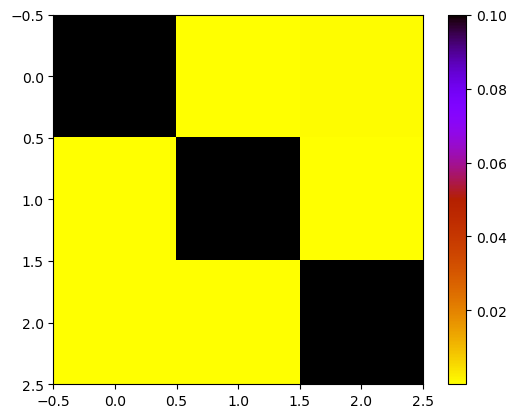

In [30]:
plt.imshow(pcca.coarse_grained_transition_matrix, vmax=0.1, cmap="gnuplot_r")
plt.colorbar()

The membership probabilities can be accessed via pcca.memberships, where each column corresponds to a metastable set defining a probability distribution over the microstates:

In [31]:
print(f"Memberships: {pcca.memberships.shape}")

Memberships: (250, 3)


In [32]:
features = curated_features

In [33]:
features.shape

(706452, 8)

In [34]:
features[:,0]

array([0.29875837, 0.23951209, 0.26047674, ..., 0.11644186, 0.16010046,
       0.14381143])

In [35]:
def plot_assign_probs(f1,f2):
    fig, axes = plt.subplots(1, pcca.memberships.shape[1], figsize=(15, 6))
    
    for i in range(len(axes)):
        ax = axes[i]
        #ax.set_title(f"Metastable set {i+1} assignment prob")
        ax.set_title(f"State {i} assignment prob")
    
        #ax.scatter(*data.T, c=pcca.memberships[assignments, i], cmap=plt.cm.Blues)
        #ax.hexbin(*features[:,:2].T, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
        #ax.hexbin(*features[:,-2:].T, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
        #ax.hexbin(features[:,2], features[:,-1], C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
        ax.hexbin(f1, f2, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8);

In [36]:
plot_assign_probs(oa1, oa2)

In [ ]:
plot_assign_probs(tt, c2)

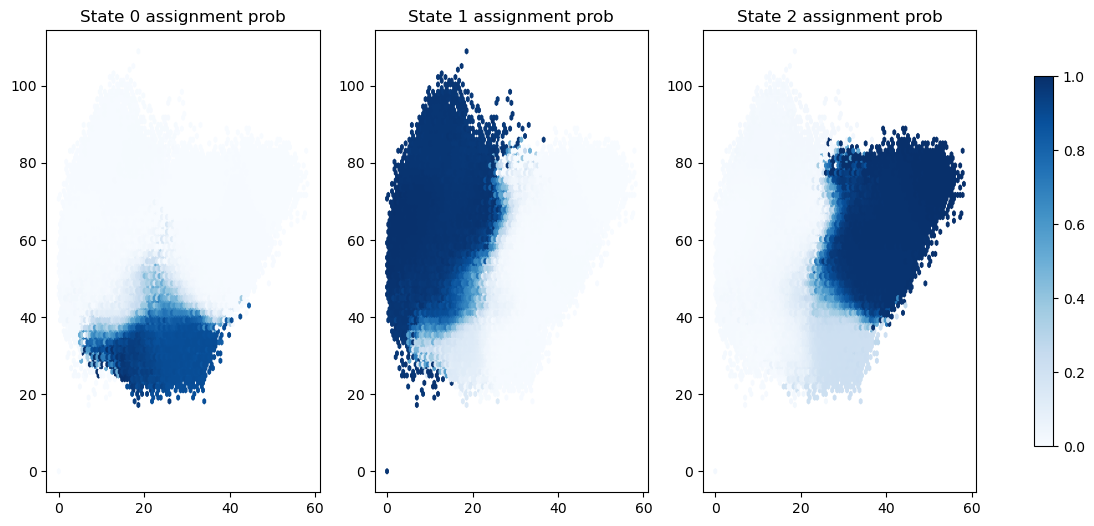

In [473]:
plot_assign_probs(oa1, c2)

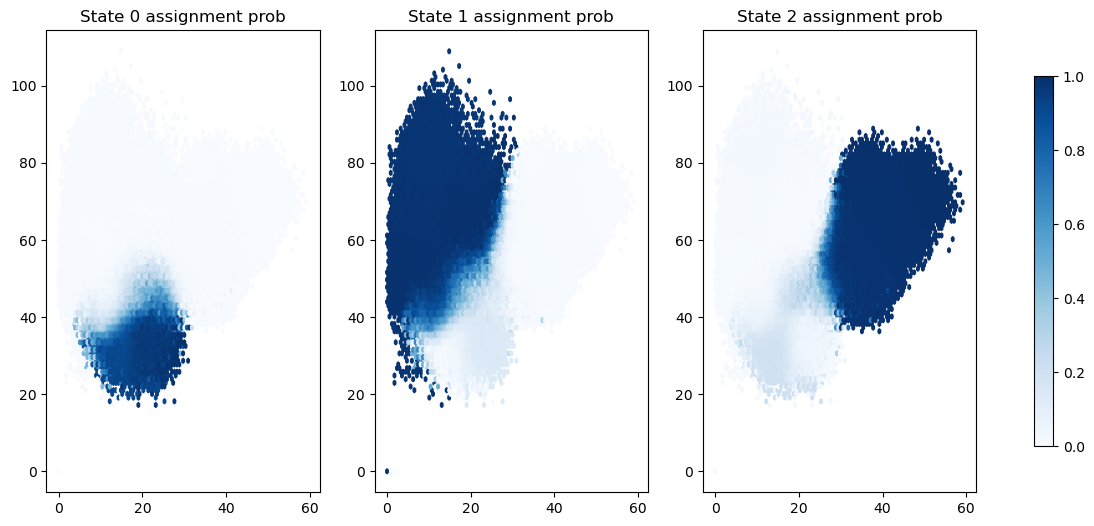

In [474]:
plot_assign_probs(oa2, c2)

Plot on the original chi1 angles:

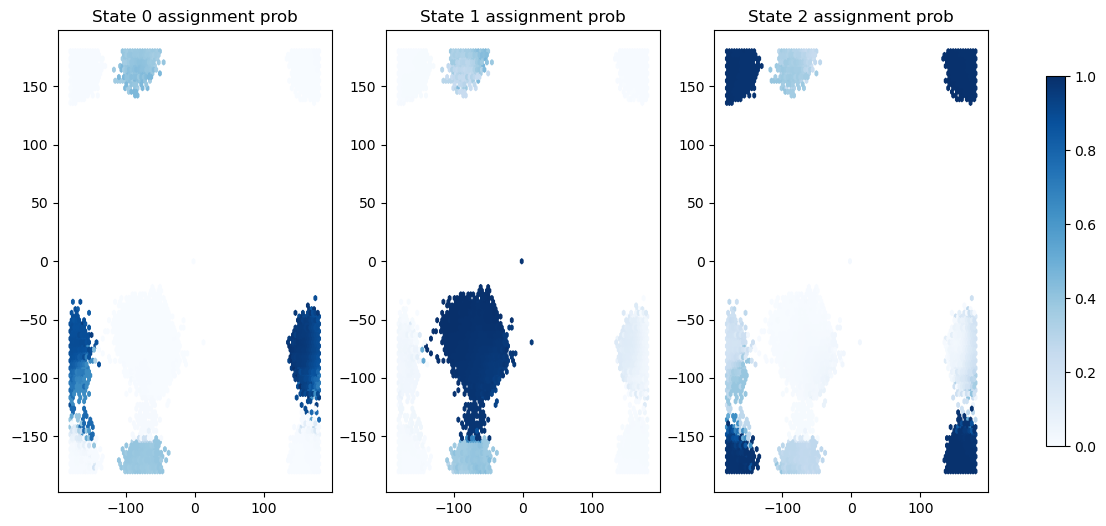

In [475]:
plot_assign_probs(m1x1, m2x1)

For visualization purposes one can obtain the crisp assignments of microstates to macrostates through:

In [39]:
pcca.assignments.shape

(250,)

However caution is appropriate, one cannot compute any actual quantity of the coarse-grained kinetics without employing the fuzzy memberships.

In [38]:
final_msm.transition_matrix_tolerance

1e-06

(<Axes: >,
 {0: array([-0.13498783,  1.        ]),
  1: array([ 0.96704829, -0.36213611]),
  2: array([-0.83206045, -0.63786389])})

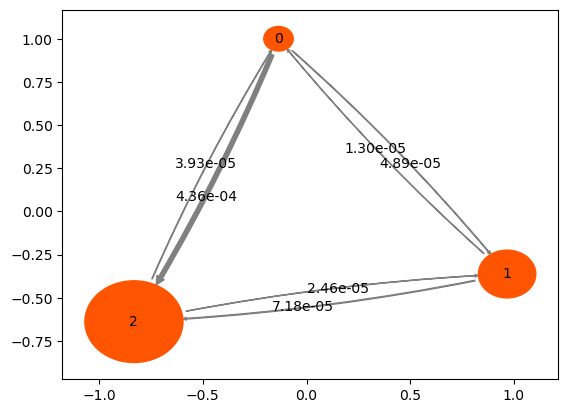

In [39]:
deeptime.plots.plot_markov_model(pcca.coarse_grained_transition_matrix)

### Making full state map

In [453]:
pcca.memberships.shape

(250, 3)

In [454]:
c2.shape

(706452,)

In [455]:
pcca.assignments[final_dtrajs].shape

(706452,)

In [632]:
# get color labels
cmap = np.array(["#377eb8", "#ff7f00", "#4daf4a", "#f781bf"])
colors = [cmap[label] for label in pcca.assignments[final_dtrajs]]

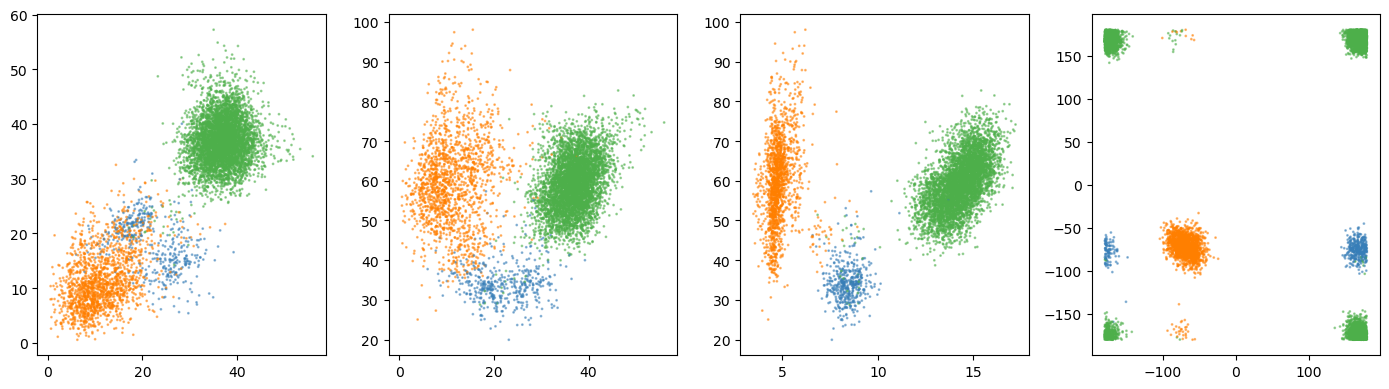

In [633]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=4)
ax[0].scatter(oa1[::100], oa2[::100], c=colors[::100], s=1, alpha=0.5)
ax[1].scatter(oa1[::100], c2[::100], c=colors[::100], s=1, alpha=0.5)
ax[2].scatter(tt[::100], c2[::100], c=colors[::100], s=1, alpha=0.5)
ax[3].scatter(m1x1[::100], m2x1[::100], c=colors[::100], s=1, alpha=0.5)
fig.tight_layout()

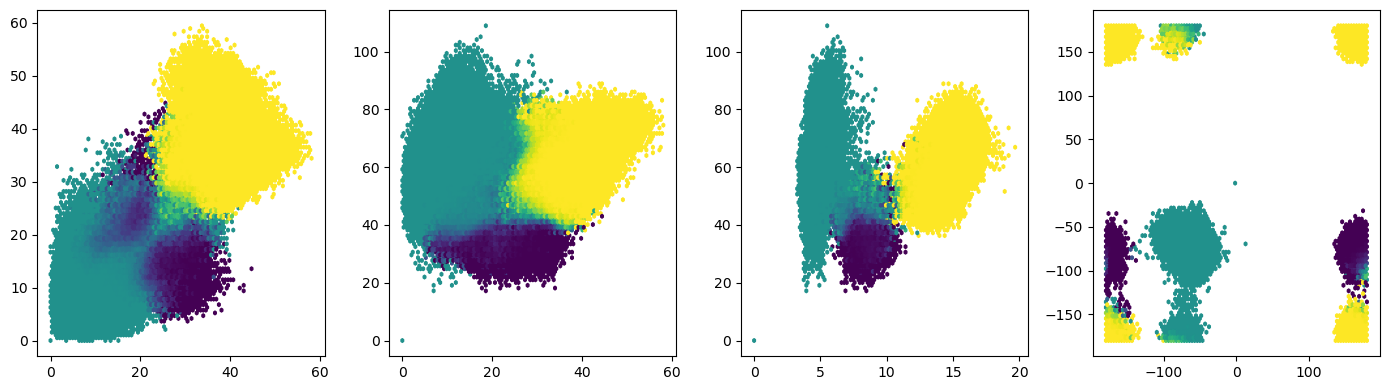

In [634]:
fig, ax = plt.subplots(figsize=(14, 4), ncols=4)
plot = ax[0].hexbin(oa1, oa2, pcca.assignments[final_dtrajs], vmin=0)
plot = ax[1].hexbin(oa1, c2, pcca.assignments[final_dtrajs], vmin=0)
plot = ax[2].hexbin(tt, c2, pcca.assignments[final_dtrajs], vmin=0)
plot = ax[3].hexbin(m1x1, m2x1, pcca.assignments[final_dtrajs], vmin=0)
#deeptime.plots.plot_contour2d_from_xyz(oa1, c2, pcca.memberships[final_dtrajs,0])
#ax.set_xlabel('IC 1')
#ax.set_ylabel('IC 2')
#ax.cbar.set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
#                             for i in range(4)])
#plt.colorbar(plot)
fig.tight_layout()

In [560]:
print('state\tπ\t\tG/kT')
for i, p in enumerate(pcca.coarse_grained_stationary_probability):
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G/kT
1	0.047498	3.047073
2	0.244941	1.406737
3	0.707561	0.345931


In [275]:
pcca._pi_coarse

array([0.04749776, 0.24494115, 0.70756109])

In [276]:
pcca.coarse_grained_stationary_probability

array([0.04749776, 0.24494115, 0.70756109])

### More flux plots

In [ ]:
from deeptime.plots import plot_markov_model, Network, plot_flux
from deeptime.markov.msm import MarkovStateModel
import networkx as nx

from mpl_toolkits.axes_grid1 import make_axes_locatable

f, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax in axes.flatten():
    ax.set_aspect('equal')

ax = axes[0][0]
ax.set_title('Plotting the Markov model')

P = pcca.coarse_grained_transition_matrix
plot_markov_model(P, ax=ax)

ax = axes[0][1]
ax.set_title('Plotting the gross flux')

# 3 to 2 is D1 --> D2
flux = MarkovStateModel(P).reactive_flux(source_states=[2], target_states=[1])
positions = nx.planar_layout(nx.from_numpy_array(flux.gross_flux))
cmap = mpl.cm.get_cmap('coolwarm')
network = Network(flux.gross_flux, positions, edge_curvature=2.,
               state_colors=flux.forward_committor, cmap=cmap)
network.plot(ax=ax)
norm = mpl.colors.Normalize(vmin=np.min(flux.forward_committor), vmax=np.max(flux.forward_committor))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(mpl.cm.ScalarMappable(norm, cmap), cax=cax)

ax = axes[1][0]
ax.set_title('Plotting the net flux')
ax.get_yaxis().set_visible(False)
plot_flux(flux, attribute_to_plot='net_flux', ax=ax)

f.delaxes(axes[1][1])

/scratch/slurm-16420477/ipykernel_39246/2583892410.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


### TPT and flux plotting:

### TODO: get rates with error bars

Example:
* Internal Markov state model with 100 states to cover the (10, 10) grid.
* Compute reactive flux from A=[88, 98, 89, 99] to B=[0, 10, 1, 11]

In [389]:
pcca.assignments

array([1, 2, 0, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 0, 0, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 2, 0,
       2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 1, 0, 1, 2, 2, 2,
       0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0,
       1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 2, 2, 1,
       1, 2, 0, 2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1,
       0, 2, 1, 0, 0, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 1, 2, 1,
       1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 0, 2, 1, 2, 0, 1,
       2, 1, 2, 2, 2, 2, 1, 2])

In [41]:
a = pcca.assignments
#np.where(a==7)[0]

#### In my case I want the flux from state A (D1) to state B (D2)

In [42]:
stateA = 2
stateB = 1

In [43]:
mfpt = final_msm.mfpt(np.where(a==stateA)[0], np.where(a==stateB)[0])
mfpt

34347.48755089352

In [44]:
flux = final_msm.reactive_flux(np.where(a==stateA)[0], np.where(a==stateB)[0])

In [45]:
flux.mfpt

34338.99708349201

In [46]:
flux.rate

2.9121409619756657e-05

In [47]:
cg_flux = flux.coarse_grain((np.where(a==stateA)[0], np.where(a==stateB)[0]))

In [48]:
cg_flux[-1]

ReactiveFlux-140670183969872:[{'gross_flux': array([[0.00000000e+00, 3.17247477e-06, 1.86991990e-05],
                                    [0.00000000e+00, 0.00000000e+00, 3.17247476e-06],
                                    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
                              'net_flux': array([[0.00000000e+00, 3.17247477e-06, 1.86991990e-05],
                                    [0.00000000e+00, 0.00000000e+00, 3.17247476e-06],
                                    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
                              'qminus': None,
                              'qplus': None,
                              'source_states': [0],
                              'stationary_distribution': array([0.69498585, 0.06276223, 0.24225191]),
                              'target_states': [2]}]

In [49]:
dir(cg_flux[-1])

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_compute_coarse_sets',
 '_gross_flux',
 '_kAB',
 '_net_flux',
 '_pathways_to_flux',
 '_qminus',
 '_qplus',
 '_source_states',
 '_stationary_distribution',
 '_target_states',
 '_totalflux',
 'backward_committor',
 'coarse_grain',
 'copy',
 'forward_committor',
 'get_params',
 'gross_flux',
 'intermediate_states',
 'major_flux',
 'mfpt',
 'n_states',
 'net_flux',
 'pathways',
 'rate',
 'set_params',
 'source_states',
 'stationary_distribution',
 'target_states',
 'total_flux']

(<Axes: xlabel='Committor probability'>,
 array([[0.        , 0.4903817 ],
        [0.10670023, 1.        ],
        [1.        , 0.        ]], dtype=float32))

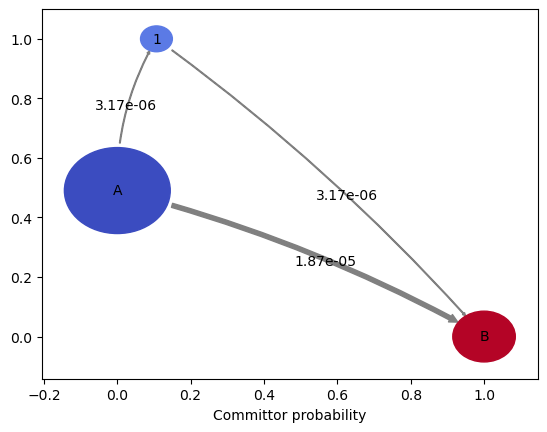

In [50]:
deeptime.plots.plot_flux(cg_flux[-1])

#### State 1 to state 2 is D2 to D1

In [51]:
# D1 --> D2
flux.rate, flux.mfpt

(2.9121409619756657e-05, 34338.99708349201)

In [52]:
cg_flux[-1].rate, cg_flux[-1].mfpt

(2.9121409619756657e-05, 34338.99708349201)

In [53]:
flux_r = final_msm.reactive_flux(np.where(a==stateB)[0], np.where(a==stateA)[0])

In [54]:
flux_r.rate

8.785616113823406e-05

In [55]:
flux_r.mfpt

11382.241006713082

In [575]:
# Kd = k_12 / k_21
flux.rate / flux_r.rate

0.3429412664408256

In [576]:
cg_pops = pcca.coarse_grained_stationary_probability
cg_pops

array([0.04749776, 0.24494115, 0.70756109])

In [81]:
cg_flux[-1].stationary_distribution

array([0.70360544, 0.05335309, 0.24304147])

In [82]:
# Kd = [D2] / [D1]
cg_pops[stateB] / cg_pops[stateA]

0.3461766753064175

In [83]:
# Kd = [D2] / [D1] from cg_flux
cg_flux[-1].stationary_distribution[-1] / cg_flux[-1].stationary_distribution[0]

0.345422952052353

(<Axes: xlabel='Committor probability'>,
 array([[0.        , 0.7105286 ],
        [0.83265454, 0.        ],
        [1.        , 1.        ]], dtype=float32))

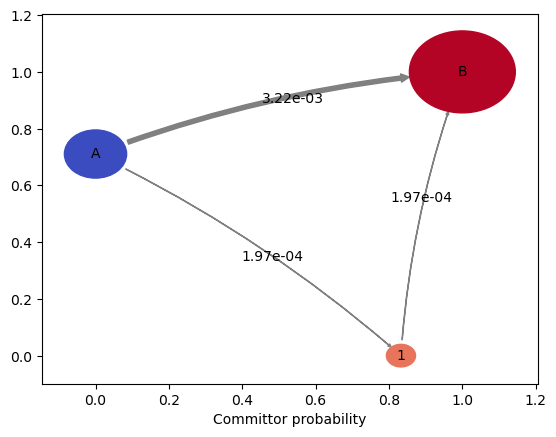

In [404]:
deeptime.plots.plot_flux(flux_r.coarse_grain((np.where(a==stateB)[0], np.where(a==stateA)[0]))[-1])

What is the identity of each of these states?

In [320]:
cg_flux[-1].forward_committor

array([0.        , 0.50871222, 1.        ])

In [321]:
cg_flux[-1].backward_committor

array([1.        , 0.49128778, 0.        ])

In [329]:
# these are the state assignments
cg_flux[0]

[{0,
  3,
  4,
  7,
  10,
  12,
  13,
  14,
  15,
  19,
  20,
  22,
  24,
  26,
  28,
  30,
  31,
  32,
  35,
  36,
  37,
  38,
  40,
  41,
  46,
  47,
  52,
  56,
  60,
  61,
  62,
  63,
  65,
  66,
  70,
  71,
  75,
  76,
  77,
  79,
  82,
  84,
  86,
  87,
  88,
  94,
  95,
  98,
  99,
  102,
  103,
  106,
  107,
  108,
  111,
  112,
  114,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  126,
  127,
  128,
  129,
  130,
  131,
  134,
  136,
  137,
  139,
  140,
  141,
  144,
  145,
  150,
  152,
  153,
  155,
  156,
  157,
  160,
  161,
  163,
  164,
  167,
  170,
  173,
  174,
  177,
  182,
  183,
  185,
  186,
  188,
  190,
  192,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  206,
  208,
  209,
  210,
  211,
  218,
  221,
  225,
  226,
  227,
  228,
  229,
  230,
  232,
  235,
  236,
  238,
  239,
  240,
  242,
  243,
  247,
  248,
  252,
  253,
  255,
  257,
  258,
  259,
  260,
  261,
  262,
  265,
  266,
  269,
  270,
  271,
  274,
  275,
  276,
  277,
  2

In [345]:
np.array(list(cg_flux[0][1]))

array([  2,   5,   6,  16,  18,  23,  27,  29,  33,  34,  42,  43,  44,
        48,  50,  51,  53,  57,  58,  59,  64,  67,  78,  81,  90,  92,
        93,  96, 101, 104, 105, 110, 115, 124, 125, 133, 135, 146, 147,
       148, 149, 154, 158, 165, 171, 172, 175, 176, 178, 181, 184, 187,
       189, 191, 194, 195, 204, 207, 216, 217, 219, 220, 222, 223, 224,
       231, 234, 241, 244, 245, 251, 254, 256, 267, 272, 273, 278, 279,
       280, 286, 291, 294, 296, 297, 302, 306, 307, 314, 316, 351, 369,
       371, 373, 374, 376, 377, 381, 383, 384, 388, 391, 396, 411, 414,
       419, 423, 424, 425, 428, 431, 433, 434, 439, 444, 447])

In [348]:
final_dtrajs.shape

(5236748,)

In [352]:
pcca.memberships.shape

(450, 6)

In [349]:
# TODO: make cg_flux assignments into state labels, then use state labels to plot each microstate cluster cg assignment


In [ ]:
fig, axes = plt.subplots(1, len(cg_flux[0]), figsize=(15, 6))

for i in range(len(axes)):
    ax = axes[i]
    #ax.set_title(f"Metastable set {i+1} assignment prob")
    ax.set_title(f"State {i} assignment prob")

    #ax.scatter(*data.T, c=pcca.memberships[assignments, i], cmap=plt.cm.Blues)
    #ax.hexbin(*features[:,:2].T, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
    #ax.hexbin(*features[:,-2:].T, C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
    #ax.hexbin(features[:,2], features[:,-1], C=pcca.memberships[final_dtrajs, i], cmap=plt.cm.Blues)
    #ax.hexbin(f1, f2, C=cg_flux[0][final_dtrajs, i], cmap=plt.cm.Blues)
    ax.hexbin(features[:,0], features[:,1], C=np.array(list(cg_flux[0][i])), cmap=plt.cm.Blues)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Blues), ax=axes, shrink=.8);

Decompose flux into pathways? Only one intermediate state so...

In [ ]:
cg_flux[-1].pathways

### Bayesian MSM for flux stats

In [618]:
lag=200

In [619]:
final_lag = lag
index = -1
final_cluster= clusters[index]
final_dtrajs = dtrajs[index][:]
estimator = deeptime.markov.TransitionCountEstimator(final_lag, 'sliding')
final_count = estimator.fit(final_dtrajs).fetch_model()
estimator = deeptime.markov.msm.MaximumLikelihoodMSM(reversible=True, stationary_distribution_constraint=None)
final_msm = estimator.fit(final_count, lagtime=None).fetch_model()

In [620]:
# 3 states seems to work well
pcca = final_msm.pcca(n_metastable_sets=3)

In [621]:
a = pcca.assignments

In [622]:
np.where(a==stateA)[0]

array([  1,   4,   6,   9,  10,  11,  12,  14,  16,  18,  19,  20,  21,
        22,  25,  26,  30,  31,  32,  34,  35,  39,  40,  41,  43,  45,
        46,  47,  48,  49,  52,  53,  56,  58,  59,  62,  63,  64,  66,
        68,  70,  71,  72,  75,  76,  79,  80,  85,  86,  87,  89,  91,
        93,  94,  95,  96,  97,  99, 100, 101, 102, 104, 105, 108, 111,
       112, 114, 118, 119, 121, 123, 125, 126, 127, 128, 130, 131, 132,
       133, 135, 136, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 152, 156, 157, 159, 160, 161, 162, 163, 164, 165, 167, 169,
       170, 173, 174, 177, 179, 180, 182, 183, 185, 187, 189, 190, 191,
       192, 193, 194, 196, 199, 204, 205, 207, 209, 211, 216, 218, 221,
       222, 223, 226, 227, 228, 229, 230, 233, 235, 237, 239, 242, 244,
       245, 246, 247, 249])

In [623]:
np.where(a==stateB)[0]

array([  0,   3,   5,   7,   8,  13,  17,  23,  24,  29,  33,  36,  37,
        38,  42,  44,  51,  54,  55,  60,  67,  69,  73,  74,  77,  78,
        82,  84,  90,  92,  98, 103, 106, 107, 109, 110, 113, 115, 116,
       117, 120, 124, 134, 137, 139, 151, 154, 155, 166, 168, 172, 175,
       176, 181, 186, 188, 195, 197, 200, 203, 206, 208, 210, 212, 214,
       215, 217, 219, 220, 224, 225, 231, 232, 234, 238, 241, 243, 248])

In [624]:
estimator = deeptime.markov.TransitionCountEstimator(lagtime=lag, count_mode='effective')
final_bmsm = BayesianMSM().fit_fetch(estimator.fit_fetch(final_dtrajs))

In [625]:
bmsm_fluxes_d1d2 = final_bmsm.evaluate_samples('reactive_flux', 
                                          source_states=np.where(a==stateA)[0], 
                                          target_states=np.where(a==stateB)[0])
bmsm_fluxes_d2d1 = final_bmsm.evaluate_samples('reactive_flux', 
                                          source_states=np.where(a==stateB)[0], 
                                          target_states=np.where(a==stateA)[0])

In [626]:
def calc_bmsm_flux_errors(bmsm_fluxes):
    """
    Returns the mean +/- std for bmsm reactive flux: 
    mean rate, std rate, mean mfpt, std mfpt
    """
    rates = []
    mfpts = []
    for m in bmsm_fluxes:
        rates.append(m.rate)
        mfpts.append(m.mfpt)
    return {"mean rate":np.mean(rates), "std rate":np.std(rates), 
            "mean mfpt":np.mean(mfpts), "std mfpt":np.std(mfpts)}

In [627]:
d1d2 = calc_bmsm_flux_errors(bmsm_fluxes_d1d2)

In [628]:
d2d1 = calc_bmsm_flux_errors(bmsm_fluxes_d2d1)

Now propagate error to get $K_{ex}=\frac{k_{12}}{k_{21}}$

In [629]:
Kex = d1d2["mean rate"] / d2d1["mean rate"]

Error propagation from division of rates:

Given $z = \frac{x}{y}$ :

$\frac{\Delta{Z}}{Z} = \sqrt{(\frac{\Delta{x}}{x})^2 + (\frac{\Delta{y}}{y})^2 + ...}$

Solving for $\Delta{Z}$:

In [630]:
K_error = Kex * np.sqrt((d1d2["std rate"] / d1d2["mean rate"])**2 + (d2d1["std rate"] / d2d1["mean rate"])**2)

In [631]:
print(f"k_12 = {d1d2['mean rate']:0.3f} ± {d1d2['std rate']:0.5f}")
print(f"k_21 = {d2d1['mean rate']:0.3f} ± {d2d1['std rate']:0.5f}")
print(f"K_ex = {Kex:0.3f} ± {K_error:0.5f}")

k_12 = 0.004 ± 0.00012
k_21 = 0.012 ± 0.00048
K_ex = 0.346 ± 0.01712


## Checkpoint 4

Cluster center pcoord values

In [224]:
np.save(f'{model_name}/final_tmatrix.npy', final_msm.transition_matrix)

In [228]:
final_cluster.cluster_centers.shape

(250, 8)

In [234]:
# Finding the index of frames closest to center
from scipy.cluster.vq import vq
cl, _ = vq(final_cluster.cluster_centers, features)

print(cl)
#np.save(f'{model_name}/closest_index.npy', cl)

[118478 368092   9398 385315 165862 574104 105909 660681 704186 169697
 691085 499558 610664 127903 377764  80702 507418 704586 594528 343267
 289486 191706 347408  15374 118990 475254 261982 355643   3483 387044
 688361 579894 672437 702282 593973 362185 307370 569799 130765 429874
 693319 397828  96580 524899 573518 598224 135726 163308 512573  42189
  10011  17227 227416 333420 540364 698743 232030  77273 278216 256134
 548447    869  44305 337077 219450 466735 423269 550190  88941 120321
 652795  38106 223320  95278 124841  87466 368679 300922 658125 552327
 621626   9283  16669 462411 406189  54028  65190 355139   5007 477758
 654734 347808  13762 255475 501499 351506 448182 519162 414665 166847
 507867 181188 270063 658996 476252  33900 705559 566054  25744 655200
 118732 207941 357730 541375 511342 697347 388672 315679 590074  37605
 314302 495334 465976 436481 570308 438353 511051 210875 186190 458723
 552646 683354 683374 214690 703207 284695  55590  97286 154895 409628
  8135

In [230]:
features[118478]

array([0.08203306, 0.12378119, 0.22769963, 0.52378676, 0.00065705,
       0.60786533, 0.01384333, 0.47621761])

In [ ]:
# Loading in the coordinates
folders = [f'{num+1:02d}' for num in range(10)]
data = []
for folder in tqdm(folders):
    data.append(np.load(f'{folder}/coords.npy'))[::10]
data_concat2 = np.concatenate(data)[::50]

In [ ]:
dihedral_concat2 = np.concatenate(dihedral)[::50]

In [ ]:
coords = {}
for idx, j in enumerate(tqdm(cl)):
    coords[idx] = data_concat2[j]
    
with open('coord_backmap.pickle', 'wb') as f:
    pickle.dump(coords, f)

In [8]:
pcoords = {}
for idx, j in enumerate(tqdm(cl)):
    pcoords[idx] = dihedral_concat2[j]
    
import pickle
with open('pcoord_backmap.pickle', 'wb') as f:
    pickle.dump(pcoords, f)

  0%|          | 0/200 [00:00<?, ?it/s]

## Figuring out the start/end states.

| oa1 | oa2 | tt | m1x1sin | m1x1cos | m2x1sin | m2x1cos | c2 |

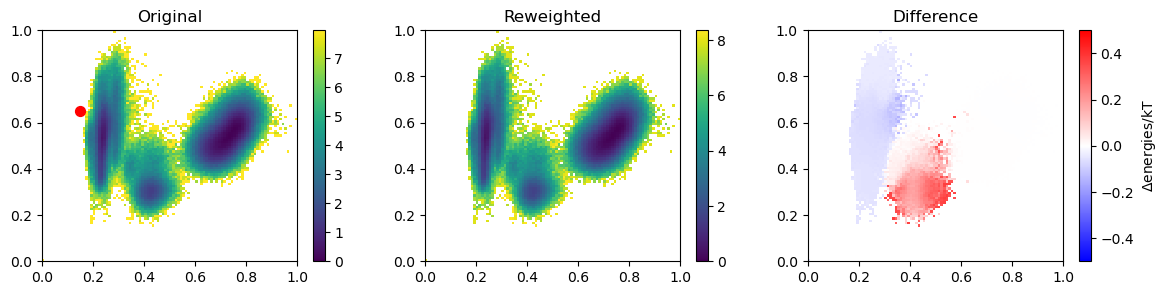

In [298]:
fig, ax = plt.subplots(ncols=3, figsize=(14,3))

f1 = features[:,2]
f2 = features[:,7]

energies = deeptime.util.energy2d(f1, f2, weights=weights[0])
energies_og = deeptime.util.energy2d(f1, f2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies)
cbar = plt.colorbar(plot)
ax[0].set_title("Original")
plot = ax[1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies)
cbar = plt.colorbar(plot)
ax[1].set_title("Reweighted")
plot = ax[2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, 
                        vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[2].set_title("Difference")
cbar.set_label('$\Delta$energies/kT')

#ax[0].scatter(0.23,0.5, s=100)
ax[0].scatter(0.15,0.65, s=50, color="red")
#ax[0].scatter(0.42,0.3, s=50, color="red")

### Get coords for states in terms of the 8 feature columns

In [213]:
from scipy.cluster.vq import vq

In [214]:
d1 = [0.62, 0.62, 0.70, 0.01, 0.65, 0.70, 0.65, 0.5]
ti = [0.35, 0.35, 0.42, 0.01, 0.65, 0.65, 0.01, 0.3]
d2 = [0.15, 0.15, 0.23, 0.65, 0.05, 0.65, 0.01, 0.5]

In [215]:
# frame index of each cluster
frames, _ = vq(final_cluster.cluster_centers, features)
#print(f"frame index per cluster:\n {frames}")

In [314]:
for state, label in zip([d1, ti, d2], ["D1", "TI", "D2"]):
    cluster, _ = vq([state], final_cluster.cluster_centers,)
    #print(f"{state}: {cluster}")
    print(f"{label}: cluster {cluster} at frame {frames[cluster]}")

D1: cluster [174] at frame [192080]
TI: cluster [184] at frame [341]
D2: cluster [69] at frame [120321]


TODO: now to relate the frames back to WE simulation interation structure...

Maybe a function to collect the paths similar to original function and then have a list of (iter,seg) for each frame

In [315]:
dap = wedap.H5_Pdist("west-13k-dmat.h5", data_type="average")

In [317]:
def get_path_array_ordered(save_name=None, first_iter=1, tau=1):
    """
    Parameters
    ----------
    save_name : str
        Name to save data as (ext .npy), default None, which uses
        data_name.npy. Otherwise will use save_name.npy.
    first_iter : int
        First iter of the h5 file to use.
    """
    # number of states
    n_bstates = len(dap.h5["ibstates/0/bstate_index"])

    # set n_iters
    n_iters = dap.last_iter - (first_iter - 1)
    
    # pre-cast array for dataset: n_bstates * n_iters * tau
    # to be consistent with dmat, only take final frame of segment (so then tau=1)
    # here, make 2D for the (iter, seg) cols
    path_array = np.zeros((n_bstates*n_iters*tau, 2))
    
    # loop all segs in final iteration
    for bs in tqdm(range(n_bstates)):
        walker_tuple = (dap.last_iter, bs)
        path = dap.trace_walker(walker_tuple, first_iter)
        path_array[bs*n_iters*tau:(bs+1)*n_iters*tau] = path

    if save_name:
        np.save(f"{save_name}.npy", path_array)
    return path_array

Path array without first 300ns

In [326]:
path_array = get_path_array_ordered("path_array", 3000)

  0%|          | 0/68 [00:00<?, ?it/s]

In [217]:
path_array = np.load("path_array.npy")
path_array

array([[3.0000e+03, 9.0000e+00],
       [3.0010e+03, 5.1000e+01],
       [3.0020e+03, 5.0000e+00],
       ...,
       [1.3386e+04, 6.6000e+01],
       [1.3387e+04, 5.1000e+01],
       [1.3388e+04, 6.7000e+01]])

In [327]:
path_array.shape

(706452, 2)

In [328]:
features.shape

(706452, 8)

In [340]:
for state, label in zip([d1, ti, d2], ["D1", "TI", "D2"]):
    cluster, _ = vq([state], final_cluster.cluster_centers,)
    #print(f"{state}: {cluster}")
    print(f"{label}: cluster {cluster} at frame {frames[cluster]} and last frame of (iter {int(path_array[cluster][0][0])} ,seg {int(path_array[cluster][0][1])})")

D1: cluster [174] at frame [192080] and last frame of (iter 3174 ,seg 9)
TI: cluster [184] at frame [341] and last frame of (iter 3184 ,seg 45)
D2: cluster [69] at frame [120321] and last frame of (iter 3069 ,seg 14)


In [218]:
for state, label in zip([d1, ti, d2], ["D1", "TI", "D2"]):
    cluster, _ = vq([state], final_cluster.cluster_centers,)
    #print(f"{state}: {cluster}")
    print(f"{label}: cluster {cluster} at frame {frames[cluster]} and last frame of (iter {int(path_array[cluster][0][0])} ,seg {int(path_array[cluster][0][1])})")

D1: cluster [174] at frame [192080] and last frame of (iter 3174 ,seg 9)
TI: cluster [184] at frame [341] and last frame of (iter 3184 ,seg 45)
D2: cluster [69] at frame [120321] and last frame of (iter 3069 ,seg 14)


In [336]:
final_msm.transition_matrix[184, 69]

0.001748542011723317

---

## Final figures

* ITS
* CK tests
* original and reweighted and diff free energy landscape
* Make flux between 3 states with correct arrow sizes

In [12]:
plt.style.use("~/Apps/wedap/wedap/styles/default.mplstyle")

In [13]:
# Read previous data
with open(f'{model_name}/final.pickle','rb') as file:
    [final_cluster, final_dtrajs, final_count, final_msm] = pickle.load(file)

In [14]:
from deeptime.clustering import KMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales

In [15]:
lagtimes

[1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 750, 1000]

In [16]:
lagtimes = [1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 750, 1000]

In [17]:
models = []
for lagtime in tqdm(lagtimes):
   counts_estimator = deeptime.markov.TransitionCountEstimator(lagtime=lagtime, count_mode='effective')
   models.append(BayesianMSM().fit_fetch(counts_estimator.fit_fetch(final_dtrajs).submodel_largest()))

its_data = implied_timescales(models)

  0%|          | 0/12 [00:00<?, ?it/s]

In [18]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.size'] = 12

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))
plot_implied_timescales(its_data, n_its=5, ax=ax[0])
plot_implied_timescales(its_data, n_its=5, ax=ax[1])

ax[0].set_yscale('log')
ax[0].set_title('Implied Timescales')
ax[0].set_xlabel('lagtime (steps)')
ax[0].set_ylabel('timescale (steps)')
ax[0].axvline(200, linestyle='--', color='grey');

#ax[1].set_yscale('log')
ax[1].set_title('Implied Timescales')
ax[1].set_xlabel('lagtime (steps)')
#ax[1].set_ylabel('timescale (steps)')
ax[1].axvline(200, linestyle='--', color='grey');

fig.tight_layout()
fig.savefig(f"{model_name}/its_bmsm_final-3.pdf")

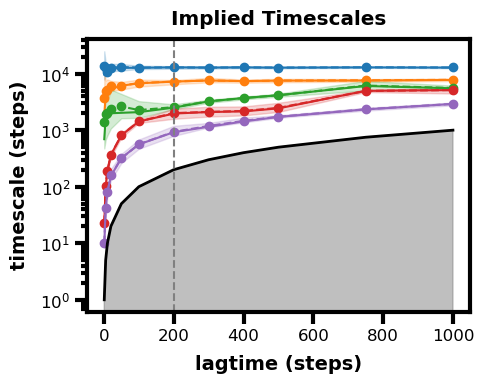

In [51]:
fig, ax = plt.subplots(figsize=(5,4))
plot_implied_timescales(its_data, n_its=5, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied Timescales')
ax.set_xlabel('lagtime (steps)')
ax.set_ylabel('timescale (steps)')
ax.axvline(200, linestyle='--', color='grey');
fig.tight_layout()
fig.savefig(f"{model_name}/its_bmsm_final-2.pdf")

---

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

/ihome/lchong/dty7/Apps/anaconda3/envs/hamsm/lib/python3.10/site-packages/deeptime/plots/chapman_kolmogorov.py:174: ComplexWarning: Your CKtest contains imaginary components which are ignored during plotting.
  warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",


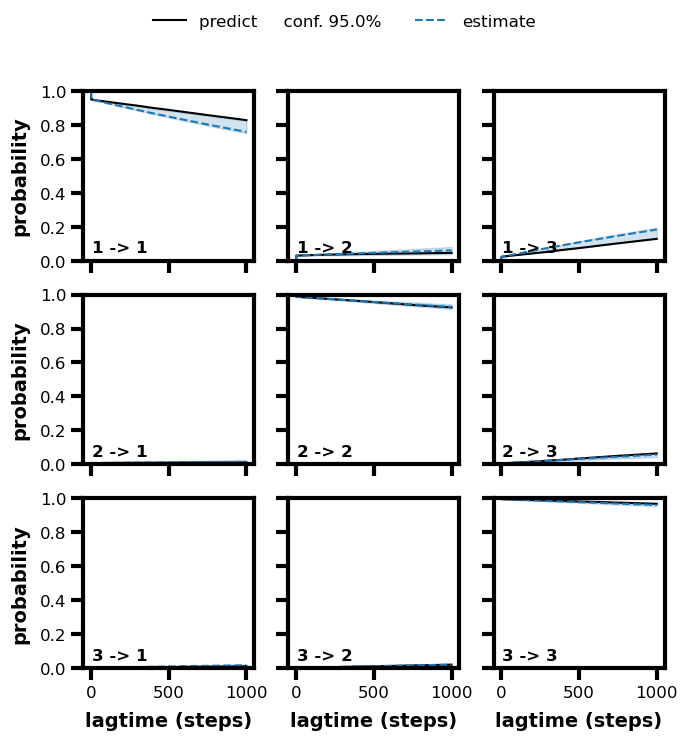

In [50]:
test_model = models[1]
ck_test = test_model.ck_test(models, n_metastable_sets=3, progress=tqdm)
grid = deeptime.plots.plot_ck_test(ck_test, legend=True)
#plt.tight_layout()
#plt.subplots(layout="constrained")
plt.savefig(f"{model_name}/ck_test-2.pdf")

In [20]:
# Read previous data
with open(f'{model_name}/final.pickle','rb') as file:
    [final_cluster, final_dtrajs, final_count, final_msm] = pickle.load(file)

In [21]:
weights = final_msm.compute_trajectory_weights(final_dtrajs)

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,6))

energies = deeptime.util.energy2d(oa1, oa2, weights=weights[0])
energies_og = deeptime.util.energy2d(oa1, oa2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0,0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label('-$\ln$(P) / kT')
ax[0,0].set_title("Original")
plot = ax[0,1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label('-$\ln$(P) / kT')
ax[0,1].set_title("Reweighted")
plot = ax[0,2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, 
                        vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[0,2].set_title("Difference")
cbar.set_label('$\Delta$ energies / kT')


energies = deeptime.util.energy2d(tt, c2, weights=weights[0])
energies_og = deeptime.util.energy2d(tt, c2)
energies_diff = energies.energies - energies_og.energies
plot = ax[1,0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label('-$\ln$(P) / kT')
plot = ax[1,1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label('-$\ln$(P) / kT')
plot = ax[1,2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, 
                        vmin=-0.5, vmax=0.5, cmap='bwr')


cbar = plt.colorbar(plot)
cbar.set_label('$\Delta$ energies / kT')

ax[0,0].set_ylabel("Orientation Angle 2 ($\degree$)")
ax[0,0].set_xlabel("Orientation Angle 1 ($\degree$)")
ax[0,1].set_xlabel("Orientation Angle 1 ($\degree$)")
ax[0,2].set_xlabel("Orientation Angle 1 ($\degree$)")

ax[1,0].set_ylabel("C$_2$ Angle ($\degree$)")
ax[1,0].set_xlabel("T188-T188 Distance ($\AA$)")
ax[1,1].set_xlabel("T188-T188 Distance ($\AA$)")
ax[1,2].set_xlabel("T188-T188 Distance ($\AA$)")

plt.subplots_adjust(hspace=0.35)

#fig.tight_layout()
fig.savefig(f"{model_name}/free_energies.pdf")

In [29]:
plt.rcParams['axes.labelsize'] = 14

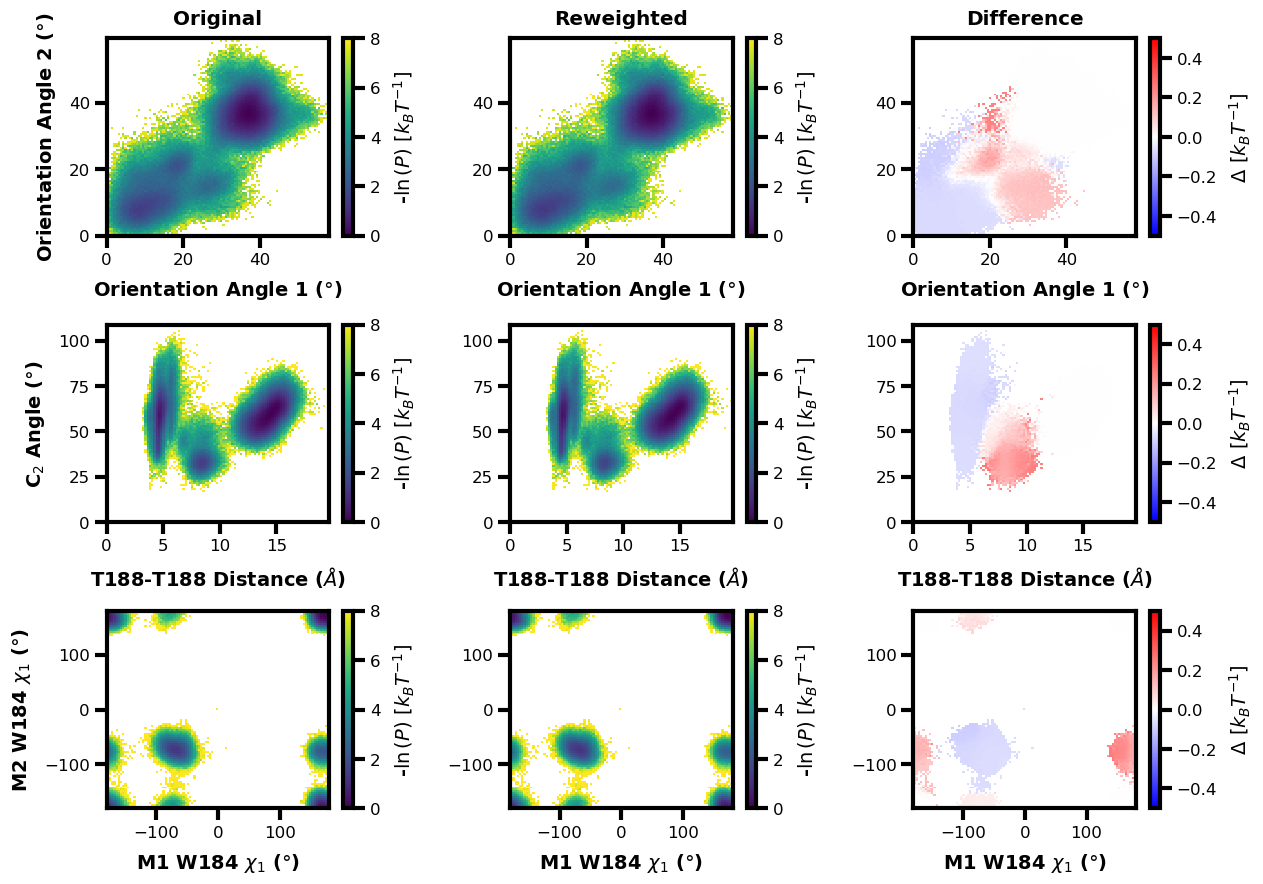

In [36]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(14,10))

pdist_label = '-$\ln$$(P)$ $[k_{B}T^{-1}]$'
diff_label = '$\Delta$ $[k_{B}T^{-1}]$'

# oas
energies = deeptime.util.energy2d(oa1, oa2, weights=weights[0])
energies_og = deeptime.util.energy2d(oa1, oa2)
energies_diff = energies.energies - energies_og.energies
plot = ax[0,0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label(pdist_label)
ax[0,0].set_title("Original")
plot = ax[0,1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label(pdist_label)
ax[0,1].set_title("Reweighted")
plot = ax[0,2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, 
                        vmin=-0.5, vmax=0.5, cmap='bwr')
cbar = plt.colorbar(plot)
ax[0,2].set_title("Difference")
cbar.set_label(diff_label)

# tt/c2
energies = deeptime.util.energy2d(tt, c2, weights=weights[0])
energies_og = deeptime.util.energy2d(tt, c2)
energies_diff = energies.energies - energies_og.energies
plot = ax[1,0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label(pdist_label)
plot = ax[1,1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label(pdist_label)
plot = ax[1,2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, 
                        vmin=-0.5, vmax=0.5, cmap='bwr')

cbar = plt.colorbar(plot)
cbar.set_label(diff_label)

# m1x1/m2x2
energies = deeptime.util.energy2d(m1x1, m2x1, weights=weights[0])
energies_og = deeptime.util.energy2d(m1x1, m2x1)
energies_diff = energies.energies - energies_og.energies
plot = ax[2,0].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_og.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label(pdist_label)
plot = ax[2,1].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies.energies, vmax=8)
cbar = plt.colorbar(plot)
cbar.set_label(pdist_label)
plot = ax[2,2].pcolormesh(energies.x_meshgrid, energies.y_meshgrid, energies_diff, 
                        vmin=-0.5, vmax=0.5, cmap='bwr')

cbar = plt.colorbar(plot)
cbar.set_label(diff_label)

ax[0,0].set_ylabel("Orientation Angle 2 ($\degree$)")
ax[0,0].set_xlabel("Orientation Angle 1 ($\degree$)")
ax[0,1].set_xlabel("Orientation Angle 1 ($\degree$)")
ax[0,2].set_xlabel("Orientation Angle 1 ($\degree$)")

ax[1,0].set_ylabel("C$_2$ Angle ($\degree$)")
ax[1,0].set_xlabel("T188-T188 Distance ($\AA$)")
ax[1,1].set_xlabel("T188-T188 Distance ($\AA$)")
ax[1,2].set_xlabel("T188-T188 Distance ($\AA$)")

ax[2,0].set_ylabel(r"M2 W184 $\chi$$_1$ ($\degree$)")
ax[2,0].set_xlabel(r"M1 W184 $\chi$$_1$ ($\degree$)")
ax[2,1].set_xlabel(r"M1 W184 $\chi$$_1$ ($\degree$)")
ax[2,2].set_xlabel(r"M1 W184 $\chi$$_1$ ($\degree$)")

plt.subplots_adjust(hspace=0.45, wspace=0.45)

#fig.tight_layout()
fig.savefig(f"{model_name}/free_energies-2.pdf")

---

In [37]:
# 3 states seems to work well
pcca = final_msm.pcca(n_metastable_sets=3)

In [38]:
# get color labels
#cmap = np.array(["#377eb8", "#ff7f00", "#4daf4a", "#f781bf"])
cmap = np.array(["#377eb8", "#ff7f00", "#4daf4a"])
cmap = np.array(["salmon", "skyblue", "navajowhite"])
color_labels = [cmap[label] for label in pcca.assignments[final_dtrajs]]

In [46]:
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'regular'
plt.rcParams['font.size'] = 11

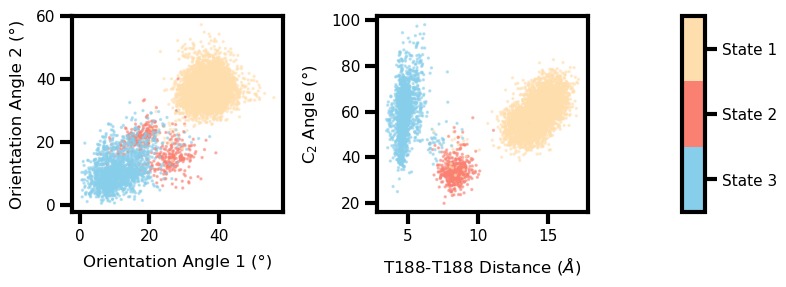

In [47]:
fig, ax = plt.subplots(figsize=(8, 3), ncols=3, gridspec_kw={'width_ratios':[1.8, 1.8, 0.2]})
ax[0].scatter(oa1[::100], oa2[::100], c=color_labels[::100], s=2, alpha=0.5)
ax[0].set(xlabel="Orientation Angle 1 (°)", ylabel="Orientation Angle 2 (°)")
data = ax[1].scatter(tt[::100], c2[::100], c=color_labels[::100], s=2, alpha=0.5)
ax[1].set(xlabel="T188-T188 Distance ($\AA$)", ylabel="C$_2$ Angle (°)")

# # define color map
# cmap = cm.get_cmap("tab10")
# # need to normalize because color maps are defined in [0, 1]
# norm = colors.Normalize(0, 2)
# # add cbar
# fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
#fig.colorbar(data, cax=ax[2])

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Define the colors in hexadecimal format
colors = ['#377eb8', '#ff7f00', '#4daf4a']
colors = ["skyblue", "salmon", "navajowhite"]
# Create a colormap object using ListedColormap
cmap = mcolors.ListedColormap(colors)
# Create a ScalarMappable with a normalization instance
norm = mcolors.Normalize(vmin=0, vmax=len(colors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You need to set a dummy array for ScalarMappable
# Create a colorbar
cbar = plt.colorbar(sm, ticks=[0.5, 1.5, 2.5], cax=ax[2])
# Customize the colorbar ticks and labels
cbar.set_ticklabels(['State 3', 'State 2', 'State 1'])

#plt.subplots_adjust(wspace=2.5)
fig.tight_layout()
fig.savefig(f"{model_name}/state_labels-2.pdf")

Can pair with structure snapshots from cluster indexing results above:
* D1: cluster [174] at frame [192080] and last frame of (iter 3174 ,seg 9)
* TI: cluster [184] at frame [341] and last frame of (iter 3184 ,seg 45)
* D2: cluster [69] at frame [120321] and last frame of (iter 3069 ,seg 14)

---

In [115]:
a = pcca.assignments
stateA = 2
stateB = 1

In [116]:
flux = final_msm.reactive_flux(np.where(a==stateA)[0], np.where(a==stateB)[0])

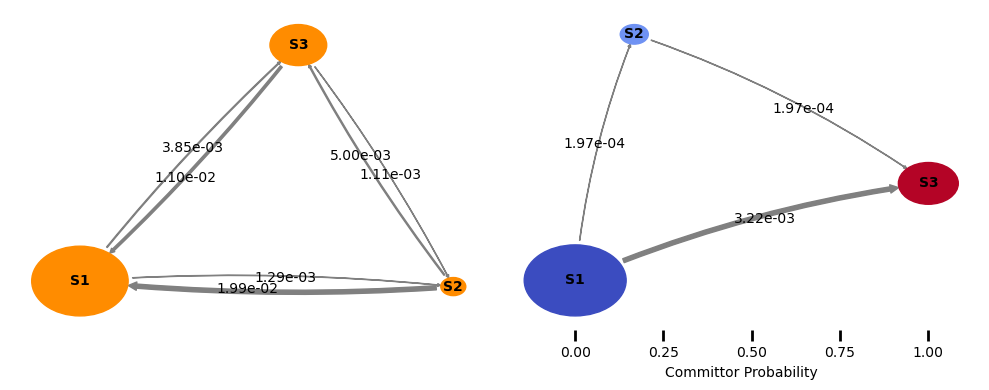

In [207]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

deeptime.plots.plot_markov_model(pcca.coarse_grained_transition_matrix, ax=ax[0], 
                                 state_colors='darkorange', fontweight="bold",
                                 state_labels=['S2', 'S3', 'S1'])
ax[0].axis("off")

deeptime.plots.plot_flux(flux.coarse_grain((np.where(a==stateA)[0], np.where(a==stateB)[0]))[-1], ax=ax[1],
                         fontweight="bold",
                         state_labels=['S1', 'S2', 'S3'])

ax[1].yaxis.set_visible(False) 
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax[1].tick_params(which='major', length=8, width=2)
ax[1].set_xlabel("Committor Probability")

fig.tight_layout()
fig.savefig(f"{model_name}/fluxplots.pdf")